#Material Backorder Prediction#

## 1. Perfomance Metric

This is an imbalanced classification problem where the number of positive points is less than the number of negative points. Positive points indicate that the product has gone to backorder while negative points indicate that the product is not in backorder. Since false negatives points  will be much harmful to buisness than predicting as False Positives so here Recall will be important metric than Precision.

* **Precision - Recall curve** :Precision-Recall curves summarize the trade-off between the true positive rate and the positive predictive value for a predictive model using different probability thresholds.A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. We will calculate area under the plot of Precision vs Recall. This will allow  business to decide on the tradeoff between Precision and Recall. 

* **F2-Score** : The intuition behind the F2 score is that it give more importance to recall than precision. This makes the F2 score more suitable  for this problem where it’s more important to classify correctly as many positive samples as possible, rather than maximizing the number of correct classifications.

* **Recall Score** : Since recall focusses more on the false negatives this will be an important metric for this problem.

* **Precision** : This metric helps to quantify the correct number of  positive predictions made therefore will help to calculate the accuracy for the minority class.

* **ROC AUC score** : This score is the measure of the ability of a classifier to distinguish between classes.Using this score we will want to compare the predictive power of each models

## 2. Extrapolatory Data Analysis

## 2.1 Importing Libraries

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import math
import itertools 
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import scipy
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize, StandardScaler
from imblearn.combine import SMOTETomek
from sklearn.metrics import confusion_matrix
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from nltk.stem.porter import PorterStemmer
import re
from matplotlib.patches import Patch
import scipy.stats as ss
from collections import Counter
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os


## 2.2 Loading Dataset

In [2]:
# Unrar the file

!unrar x "/content/dataset.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/dataset.rar

Extracting  Kaggle_Training_Dataset_v2.csv                                 0%  1%  2%  3%  4%  5%  6%  7%  8%  9% 10% 11% 12% 13% 14% 15% 16% 17% 18% 19% 20% 21% 22% 23% 24% 25% 26% 27% 28% 29% 30% 31% 32% 33% 34% 35% 36% 37% 38% 39% 40% 41% 42% 43% 44% 45% 46% 47% 48% 49% 50% 51% 52% 53% 54% 55% 56% 57% 58% 59% 60% 61% 62% 63% 64% 65% 66% 67% 68% 69% 70% 71% 72% 73% 74% 75% 76% 77% 78% 79% 80% 81% 82% 83% 84% 85% 86% 87%  OK 
Extracting  Kaggle_Test_Dataset_v2.csv                                    87% 88% 89% 90%

In [133]:
# Read the csv file

df_train=pd.read_csv("/content/Kaggle_Training_Dataset_v2.csv")

<h2> 2.3 Checking Data<h2>

In [134]:
print("Shape of the dataset is",df_train.shape)
print("Number of data points is ",df_train.shape[0])
print("Number of features is",df_train.shape[1])


Shape of the dataset is (1687861, 23)
Number of data points is  1687861
Number of features is 23


<h3> 2.3.1 Checking data structure

In [135]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Data columns (total 23 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   sku                1687861 non-null  object 
 1   national_inv       1687860 non-null  float64
 2   lead_time          1586967 non-null  float64
 3   in_transit_qty     1687860 non-null  float64
 4   forecast_3_month   1687860 non-null  float64
 5   forecast_6_month   1687860 non-null  float64
 6   forecast_9_month   1687860 non-null  float64
 7   sales_1_month      1687860 non-null  float64
 8   sales_3_month      1687860 non-null  float64
 9   sales_6_month      1687860 non-null  float64
 10  sales_9_month      1687860 non-null  float64
 11  min_bank           1687860 non-null  float64
 12  potential_issue    1687860 non-null  object 
 13  pieces_past_due    1687860 non-null  float64
 14  perf_6_month_avg   1687860 non-null  float64
 15  perf_12_month_avg  1687860 non-n



*   There are 23 columns in the dataset out of which 15 are numerical and 7 are catergorical, one column is the unique key identifier




### 2.3.2 Numerical columns

In [136]:
#Storing numerical columns in a list

df_train_num_feat=df_train.select_dtypes(include='number')
num_col_list=list(df_train_num_feat.columns)
print("Numerical columns are:\n",num_col_list)

Numerical columns are:
 ['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month', 'forecast_6_month', 'forecast_9_month', 'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg', 'local_bo_qty']


<h3> 2.3.3 Print top 10 rows of the dataset <h3>

In [137]:
df_train.head(10)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1026827,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
1,1043384,2.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.99,0.99,0.0,No,No,No,Yes,No,No
2,1043696,2.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
3,1043852,7.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,No,0.0,0.10,0.13,0.0,No,No,No,Yes,No,No
4,1044048,8.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
5,1044198,13.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.82,0.87,0.0,No,No,No,Yes,No,No
6,1044643,1095.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,No,0.0,-99.00,-99.00,0.0,Yes,No,No,Yes,No,No
7,1045098,6.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.00,0.00,0.0,Yes,No,Yes,Yes,No,No
8,1045815,140.0,NaN,0.0,15.0,114.0,152.0,0.0,0.0,0.0,0.0,0.0,No,0.0,-99.00,-99.00,0.0,No,No,No,Yes,No,No
9,1045867,4.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No,0.0,0.82,0.87,0.0,No,No,No,Yes,No,No


<h3> 2.3.4 Print last 10 rows of the dataset <h3>

In [138]:
df_train.tail(10)

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
1687851,1373539,-6.0,9.0,36.0,130.0,130.0,130.0,0.0,0.0,54.0,57.0,3.0,No,0.0,0.03,0.10,42.0,No,No,No,Yes,No,No
1687852,1478683,2.0,8.0,0.0,966.0,966.0,1116.0,47.0,512.0,1361.0,2060.0,455.0,No,0.0,0.84,0.77,46.0,No,No,No,Yes,No,No
1687853,1489920,0.0,2.0,0.0,2071.0,3025.0,3412.0,4.0,764.0,764.0,765.0,657.0,No,0.0,0.98,0.99,4.0,No,No,No,No,No,Yes
1687854,1392420,124.0,8.0,140.0,410.0,780.0,1240.0,128.0,464.0,849.0,1074.0,111.0,No,0.0,0.85,0.90,1.0,No,No,No,Yes,No,No
1687855,1407754,0.0,2.0,0.0,10.0,10.0,10.0,0.0,5.0,7.0,7.0,0.0,No,0.0,0.69,0.69,5.0,Yes,No,No,Yes,No,No
1687856,1373987,-1.0,NaN,0.0,5.0,7.0,9.0,1.0,3.0,3.0,8.0,0.0,No,0.0,-99.00,-99.00,1.0,No,No,No,Yes,No,No
1687857,1524346,-1.0,9.0,0.0,7.0,9.0,11.0,0.0,8.0,11.0,12.0,0.0,No,0.0,0.86,0.84,1.0,Yes,No,No,No,No,Yes
1687858,1439563,62.0,9.0,16.0,39.0,87.0,126.0,35.0,63.0,153.0,205.0,12.0,No,0.0,0.86,0.84,6.0,No,No,No,Yes,No,No
1687859,1502009,19.0,4.0,0.0,0.0,0.0,0.0,2.0,7.0,12.0,20.0,1.0,No,0.0,0.73,0.78,1.0,No,No,No,Yes,No,No
1687860,(1687860 rows),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




1.   The column sku is  a unique key identifier for the product which can be dropped 
2.   The lead column has NaN values which denotes  missing values present in the dataset.They need to be imputed properly
3.   Perfomance columns have -99 value which are missing values.They need to be imputed properly
4.   The last row of the dataset contain NaN values , so this row needs to be dropped.




### 2.3.5 Dropping the last record which contains NaN

In [139]:
df_train=df_train[:-1]

### 2.3.6 Count of NaNs in each column

In [140]:
df_train.isna().sum()

sku                       0
national_inv              0
lead_time            100893
in_transit_qty            0
forecast_3_month          0
forecast_6_month          0
forecast_9_month          0
sales_1_month             0
sales_3_month             0
sales_6_month             0
sales_9_month             0
min_bank                  0
potential_issue           0
pieces_past_due           0
perf_6_month_avg          0
perf_12_month_avg         0
local_bo_qty              0
deck_risk                 0
oe_constraint             0
ppap_risk                 0
stop_auto_buy             0
rev_stop                  0
went_on_backorder         0
dtype: int64



*   Only lead_time feature has NaN values which needs to be imputed properly



### 2.3.7 Statistical details of the data

In [141]:
df_train.describe()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty
count,1.687860e+06,1.586967e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06,1.687860e+06
mean,4.961118e+02,7.872267e+00,4.405202e+01,1.781193e+02,3.449867e+02,5.063644e+02,5.592607e+01,1.750259e+02,3.417288e+02,5.252697e+02,5.277230e+01,2.043724e+00,-6.872059e+00,-6.437947e+00,6.264507e-01
std,2.961523e+04,7.056024e+00,1.342742e+03,5.026553e+03,9.795152e+03,1.437892e+04,1.928196e+03,5.192378e+03,9.613167e+03,1.483861e+04,1.254983e+03,2.360165e+02,2.655636e+01,2.584333e+01,3.372224e+01
min,-2.725600e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.900000e+01,-9.900000e+01,0.000000e+00
25%,4.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.300000e-01,6.600000e-01,0.000000e+00
50%,1.500000e+01,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,8.200000e-01,8.100000e-01,0.000000e+00
75%,8.000000e+01,9.000000e+00,0.000000e+00,4.000000e+00,1.200000e+01,2.000000e+01,4.000000e+00,1.500000e+01,3.100000e+01,4.700000e+01,3.000000e+00,0.000000e+00,9.700000e-01,9.500000e-01,0.000000e+00
max,1.233440e+07,5.200000e+01,4.894080e+05,1.427612e+06,2.461360e+06,3.777304e+06,7.417740e+05,1.105478e+06,2.146625e+06,3.205172e+06,3.133190e+05,1.464960e+05,1.000000e+00,1.000000e+00,1.253000e+04


*   The values of the features are not in similiar ranges so dataset must be standardized before feeding to machine learning models for better perfomance
*   The mean value is larger than 75th percentile for most columns except lead_time and performance columns which means that the distribution of data is rightly skewed
*   The high max value compared to 75th percentile suggests that there might be outliers in the dataset
  



### 2.3.8 Check Uniqueness of the data

In [142]:
len(df_train.sku.unique())

1687860



*  There are no duplicates in the data since the count matches with the no of rows in the dataset
*  sku is the unique column which can be dropped 


### 2.3.9 Checking class balance ratio

In [143]:
df_train.went_on_backorder.value_counts()

No     1676567
Yes      11293
Name: went_on_backorder, dtype: int64

* It denotes this dataset is highly imbalanced with no of positive points(went into backorder) is very less than the no of negative points(did not went into backorder)

### 2.3.10 Pie plot of class distribution

([<matplotlib.patches.Wedge at 0x7fe69204c650>,
 [Text(-1.0997570064040294, 0.02311983705062927, 'Yes'),
  Text(1.099757004949663, -0.023119906231368732, 'No')],
 [Text(-0.5998674580385615, 0.012610820209434145, '99.331'),
  Text(0.5998674572452706, -0.012610857944382943, '0.669')])

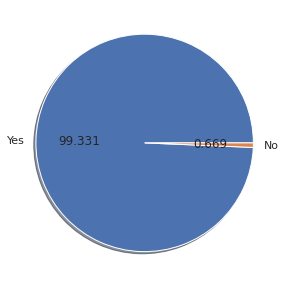

In [144]:
plt.figure(figsize=(5,5))
plt.pie(df_train['went_on_backorder'].value_counts(),autopct='%.3f',labels=['Yes','No'],shadow=True)

* Only 0.669% datapoints went into backorder while 99.331% datapoints did not went into backorder.

### 2.3.11 Skewness of the distribution

In [145]:
print(df_train.skew())

sku                    0.401787
national_inv         340.285800
lead_time              4.556295
in_transit_qty       166.183404
forecast_3_month     138.968325
forecast_6_month     138.961427
forecast_9_month     143.298875
sales_1_month        196.119990
sales_3_month        141.286380
sales_6_month        139.176712
sales_9_month        135.054191
min_bank             131.212649
pieces_past_due      412.391900
perf_6_month_avg      -3.180622
perf_12_month_avg     -3.302181
local_bo_qty         165.190548
dtype: float64




*   Since sku is a unique key identifier so its skew value is close to 0
*   Most of the columns are extremly skewed as seen from large values
*   lead_time and perfomance columns have comparatively less skewness



## 2.4 Utility Functions

In [146]:
# Function to return dataframe with given percentile ranges

def per_dataframe(df,feat,per_low_bound,per_high_bound):
  '''
  Function to return dataframe given a percentile range
    
  Inputs:
      df: pandas DataFrame
          DataFrame from which to print percentiles
      feat:string
           Column's name whose percentiles are to be calculated
      per_low_bound:  percentile
               lower bound percentile value
      per_high_bound:  percentile
               higher bound percentile value  
     
            
  Returns: 
      Dataframe with given percentile range
  '''
  return df[(df[feat]>(df[feat].quantile(per_low_bound))) & (df[feat]<(df[feat].quantile(per_high_bound)))]

# Function to return percentage of each count plot
# Referred from https://datascience.stackexchange.com/questions/48035/how-to-show-percentage-text-next-to-the-horizontal-bars-in-matplotlib

def per_annot(df,feature):
  '''
  Function to print count plot
    
  Inputs:
      df: pandas DataFrame
         Dataframe from which count plot is to be printed
      feature:string
           Independent variable name

  '''
  total = len(df[feature])
  for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2-0.05
    y = p.get_y() + p.get_height()
    ax.annotate(percentage, (x, y))

# Function to display categorical plot
# Referred from https://github.com/hoffm386/eda-with-categorical-variables/blob/master/index.ipynb

def categorical_plot(feature,tar_var):
  '''
  Function to print bar plot
    
  Inputs:
      feature: String
         Independent variable name
      tar_var:string
           Dependent variable name

  '''

  cat_counts_df = df_train.groupby([feature, tar_var])["sku"].count().unstack()

  percentage_df = (cat_counts_df.T.div(cat_counts_df.T.sum()).T)*100
  print(percentage_df)
  fig, ax = plt.subplots()
  
  #plt.figure(figsize=(12,7))
  percentage_df.plot(kind="bar", stacked=True, color=["Green", "blue"], ax=ax)

  ax.set_xlabel(feature,size=(12))
  ax.set_xticklabels(['No', 'Yes'], rotation=0)
  ax.set_ylabel("Proportion",size=(12))


  color_patches = [
    Patch(facecolor="blue", label="Backorder-Yes"),
    Patch(facecolor="Green", label="Backorder-No")
                                                    ]
  ax.legend(handles=color_patches)
  plt.show()
  fig.suptitle(feature +" vs Backorders",fontsize=15)
  


<h2>2.5 Univariate analysis <h2>

### 2.5.1 Univariate analysis of numerical features

Statistics of  national_inv

In [147]:
df_train['national_inv'].describe()

count    1.687860e+06
mean     4.961118e+02
std      2.961523e+04
min     -2.725600e+04
25%      4.000000e+00
50%      1.500000e+01
75%      8.000000e+01
max      1.233440e+07
Name: national_inv, dtype: float64

PDF of national_inv

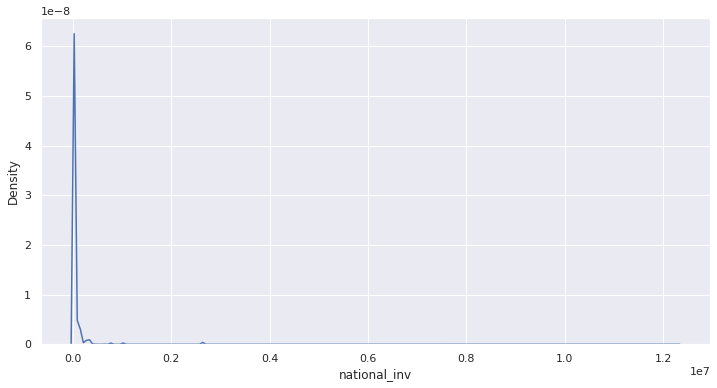

In [148]:
df_nat_inv=df_train.national_inv.values
plt.figure(figsize=(12,6))
sns.kdeplot(df_nat_inv)
plt.xlabel('national_inv')
plt.show()

*   The distribution of the data is right skewed as seen from the long tail of the distribution.
*  There is larger probability of points centred around 0.
*  There are large negative values in the national_inv column as can be verified from the peak on the negative side which suggest the these are out of stock products

Box plot of national_inv

Text(0.5, 1.0, 'Violin plot with 10-90 percentile')

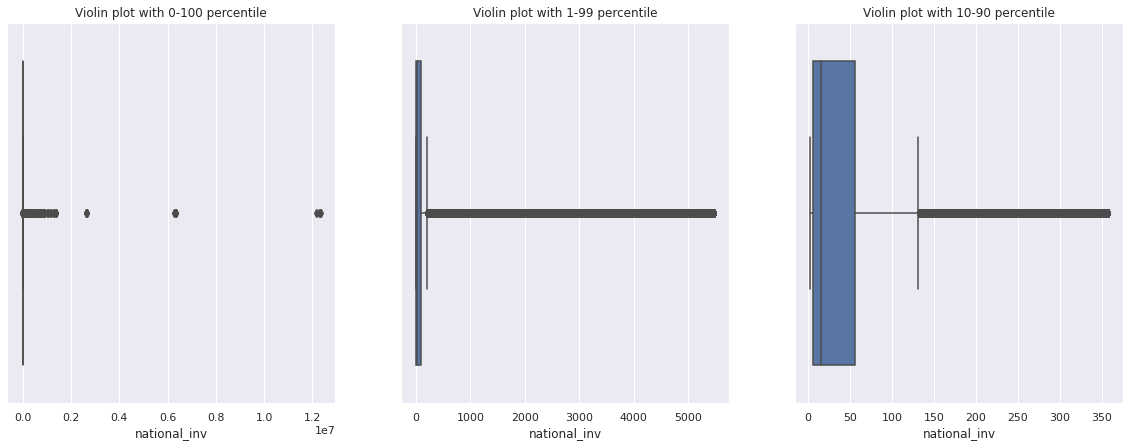

In [149]:
feature='national_inv'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df_train,ax=axes[0]).set_title('Violin plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Violin plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Violin plot with 10-90 percentile')

*   There are extreme values on the right side of the distribution
*   There is high probability of points between 25th percentile and median

Box plot of national_inv vs went_on_backorder

Text(0.5, 1.0, 'Box plot with 0-100 percentile')

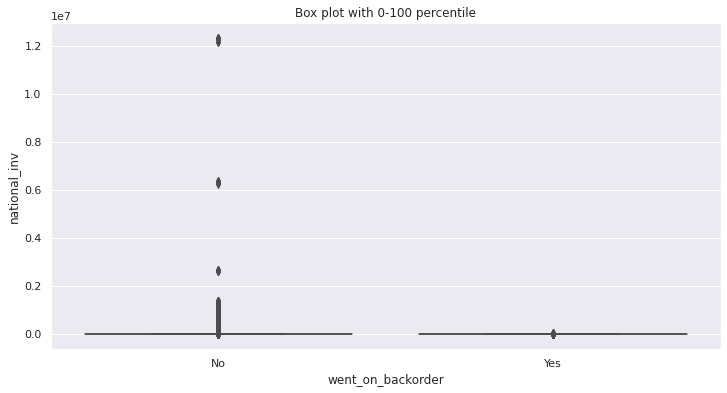

In [150]:
feature='national_inv'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='national_inv', data=df_train).set_title('Box plot with 0-100 percentile')


Text(0.5, 1.0, 'Box plot with 1-99 percentile')

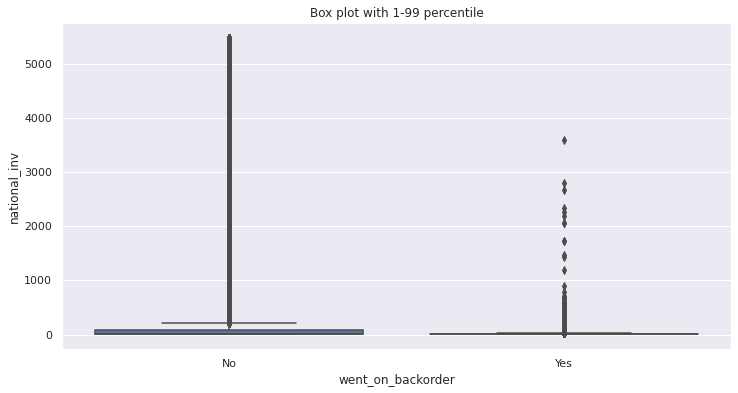

In [151]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='national_inv', data=df1).set_title('Box plot with 1-99 percentile')


Text(0.5, 1.0, 'Box plot with 10-90 percentile')

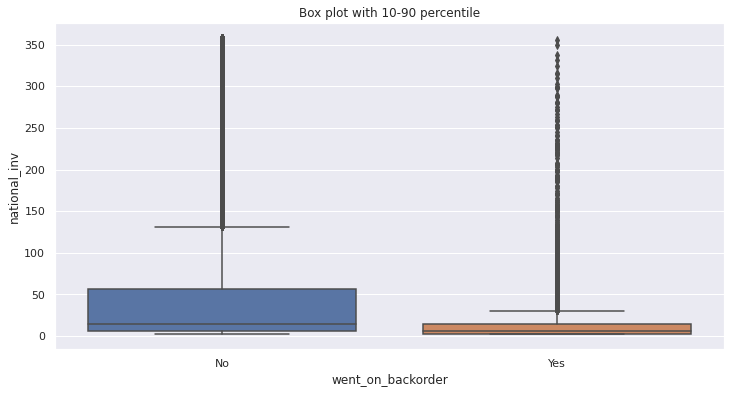

In [152]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='national_inv', data=df2).set_title('Box plot with 10-90 percentile')

*   IQR of both the distribution is less overlapping so this feature can be useful for class seperation
*   There are more extreme values in minority class than the majority class

Statistics of lead_time

In [153]:
df_train['lead_time'].describe()

count    1.586967e+06
mean     7.872267e+00
std      7.056024e+00
min      0.000000e+00
25%      4.000000e+00
50%      8.000000e+00
75%      9.000000e+00
max      5.200000e+01
Name: lead_time, dtype: float64

PDF of lead_time

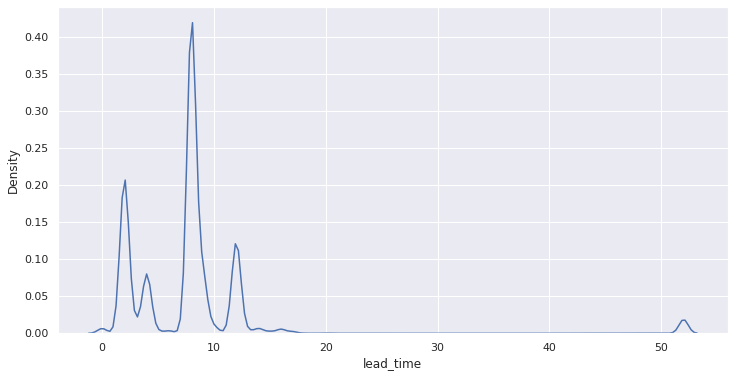

In [154]:
df_lead=df_train.lead_time.values
plt.figure(figsize=(12,6))
sns.kdeplot(df_lead)
plt.xlabel('lead_time')
plt.show()

* The plot of lead_time is extremly right skewed .This can be verified from the long tail of the distribution
* There are lot of peaks in the distribution which suggest there are lot of common values

Box plot of lead_time

Text(0.5, 1.0, 'Box plot with 0-100 percentile')

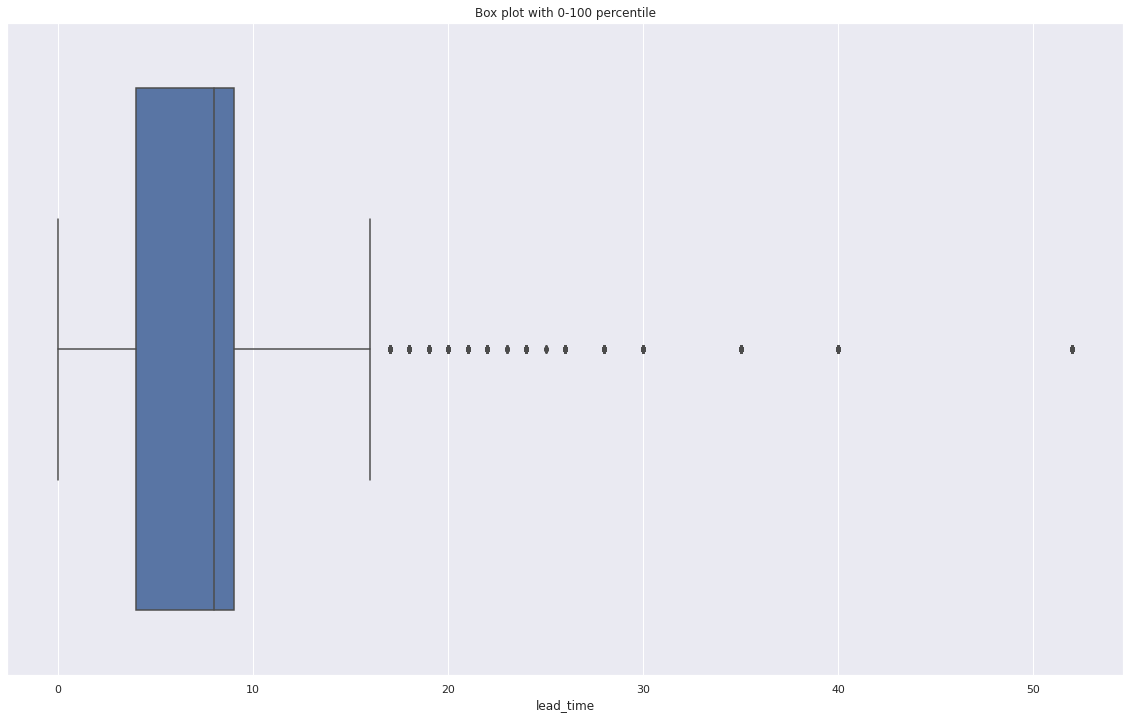

In [155]:
feature='lead_time'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
sns.boxplot(x=feature, orient='v',data=df_train).set_title('Box plot with 0-100 percentile')

*   The plot of lead_time is right skewed .This can be verified from the long tail of the distribution
*   There are extreme values on the right side of the distribution

Box plot of lead_time vs went_on_backorder

Text(0.5, 1.0, 'Box plot with 0-100 percentile')

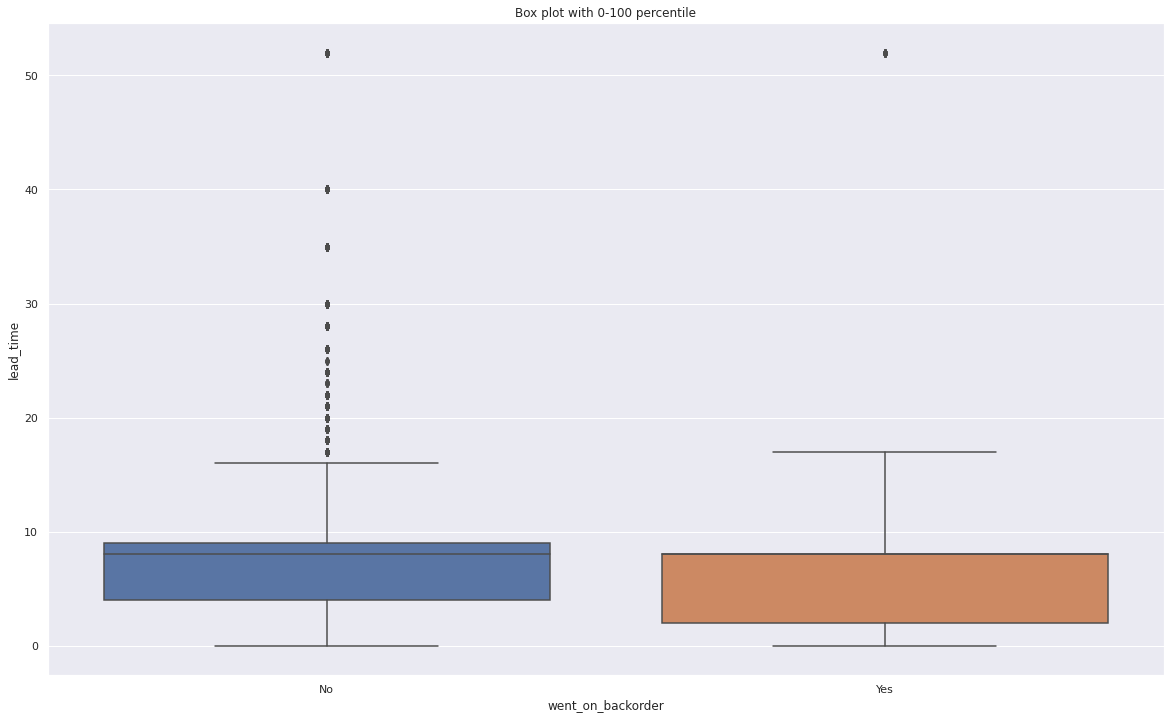

In [156]:
feature='lead_time'
sns.boxplot(x='went_on_backorder',y='lead_time', data=df_train).set_title('Box plot with 0-100 percentile')


*   IQR of both the distribution is overlapping so this feature might not be useful for class seperation
*   There are more extreme values in minority class than the majority class

Statistics of  in_transit_qty


In [157]:
df_train['in_transit_qty'].describe()

count    1.687860e+06
mean     4.405202e+01
std      1.342742e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.894080e+05
Name: in_transit_qty, dtype: float64

PDF of in_transit_qty

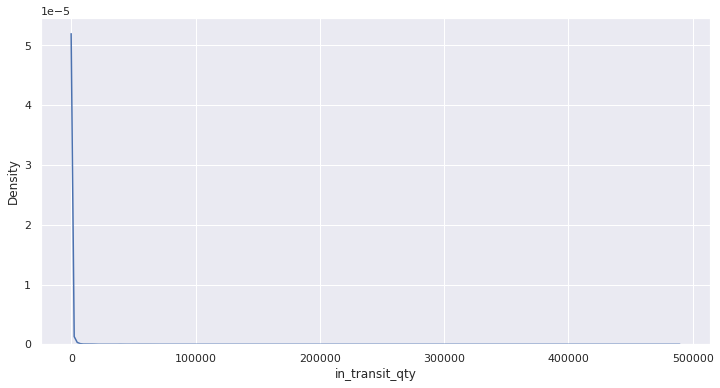

In [158]:
df_in_trans=df_train.in_transit_qty.values
plt.figure(figsize=(12,6))
sns.kdeplot(df_in_trans)
plt.xlabel('in_transit_qty')
plt.show()

* The plot of in_transit_qty is extremly right skewed .This can be verified from the long tail of the distribution
* It seems that there are lot of zero values for this column as can be seen from the peak at zero 

Box plot of in_transit_qty

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

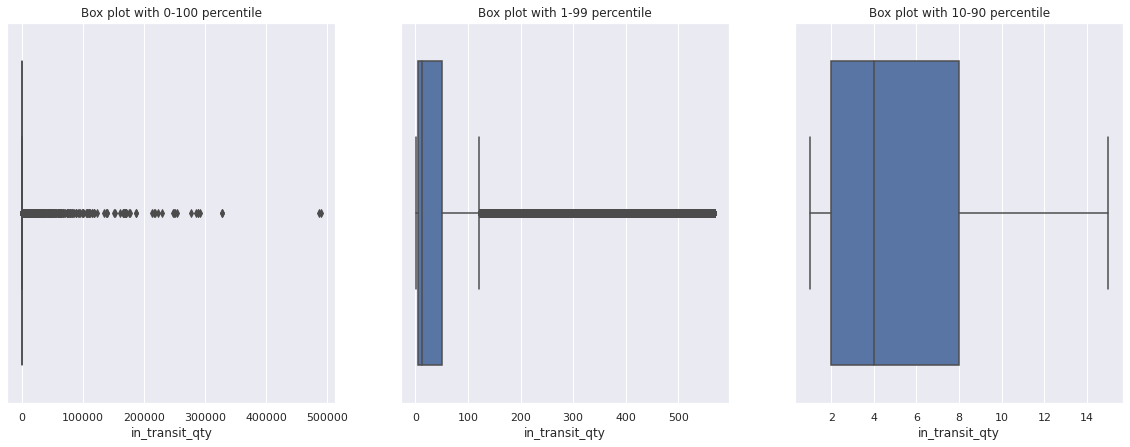

In [159]:
feature='in_transit_qty'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df_train,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

*   The plot of in_transit_qty is extremly right skewed .This can be verified from the long tail of the distribution
*   The column has outlier problem

Box plot of in_transit_qty vs went_on_backorder

Text(0.5, 1.0, 'Box plot with 0-100 percentile')

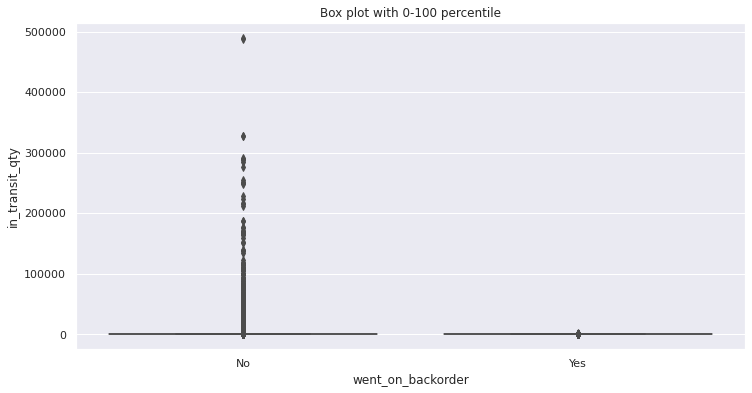

In [160]:
feature='in_transit_qty'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='in_transit_qty', data=df_train).set_title('Box plot with 0-100 percentile')

Text(0.5, 1.0, 'Box plot with 1-99 percentile')

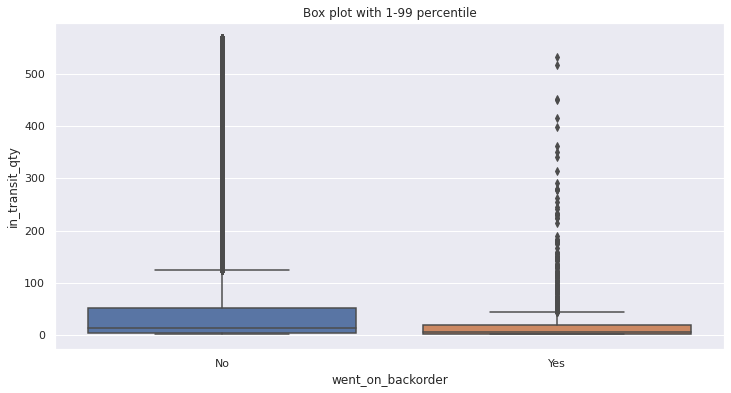

In [161]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='in_transit_qty', data=df1).set_title('Box plot with 1-99 percentile')

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

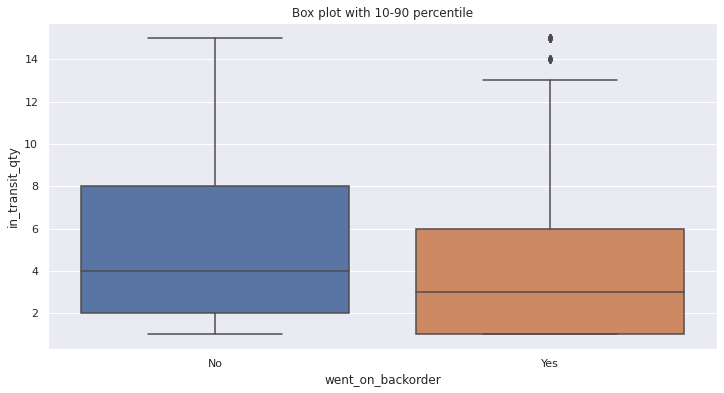

In [162]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='in_transit_qty', data=df2).set_title('Box plot with 10-90 percentile')

*   IQR of both the distribution is less overlapping so this feature might  be useful for class seperation
*   There are outliers in both positive and negative class which can be verified from long tail of the plot
*   There are more outliers in the minority class than the majority class

Statistics of  forecast_3_month

In [163]:
df_train['forecast_3_month'].describe()

count    1.687860e+06
mean     1.781193e+02
std      5.026553e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.000000e+00
max      1.427612e+06
Name: forecast_3_month, dtype: float64

PDF of forecast_3_month

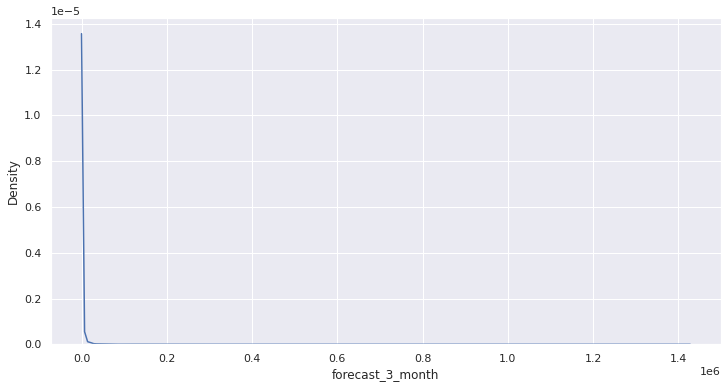

In [164]:
df_for_3mon=df_train.forecast_3_month.values
plt.figure(figsize=(12,6))
sns.kdeplot(df_for_3mon)
plt.xlabel('forecast_3_month')
plt.show()

* The plot of forecast_3_month is extremly right skewed .This can be verified from the long tail of the distribution
* It seems that there are lot of zero values for this column as can be seen from the peak at zero 

Box plot of forecast_3_month

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

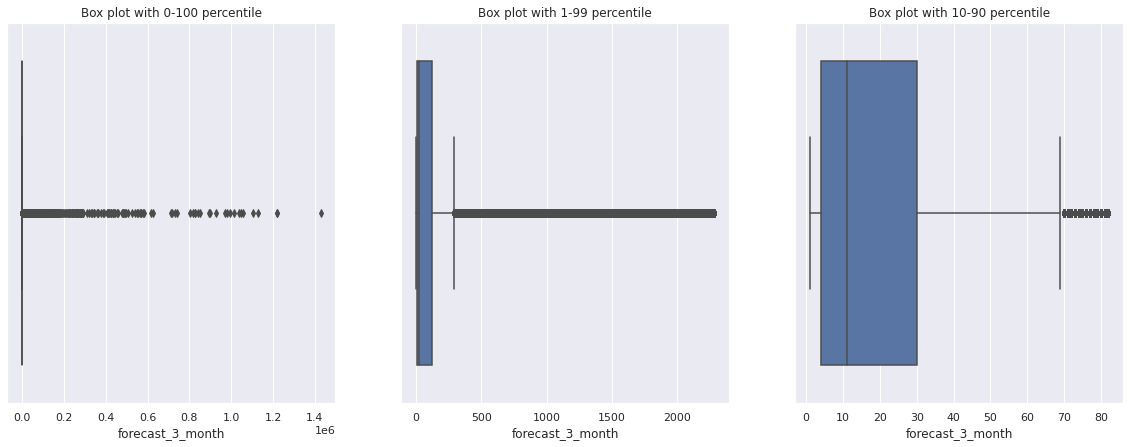

In [165]:
feature='forecast_3_month'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df_train,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

*   The plot of forecast_3_month is extremly right skewed .This can be verified from the long tail of the distribution
*   The column has outlier problem

Box plot of forecast_3_month vs went_on_backorder

Text(0.5, 1.0, 'Box plot with 0-100 percentile')

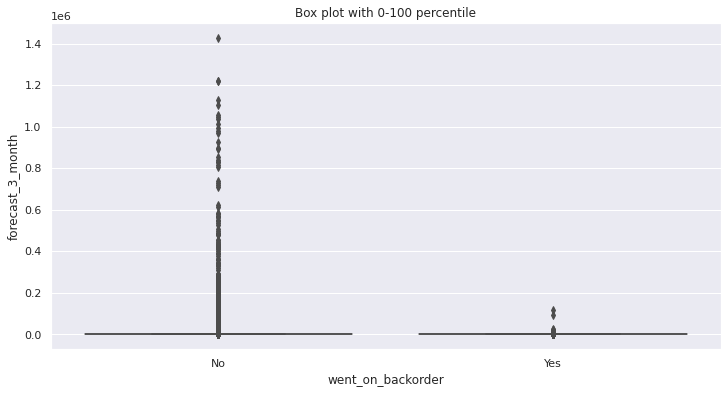

In [166]:
feature='forecast_3_month'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='forecast_3_month', data=df_train).set_title('Box plot with 0-100 percentile')

Text(0.5, 1.0, 'Box plot with 1-99 percentile')

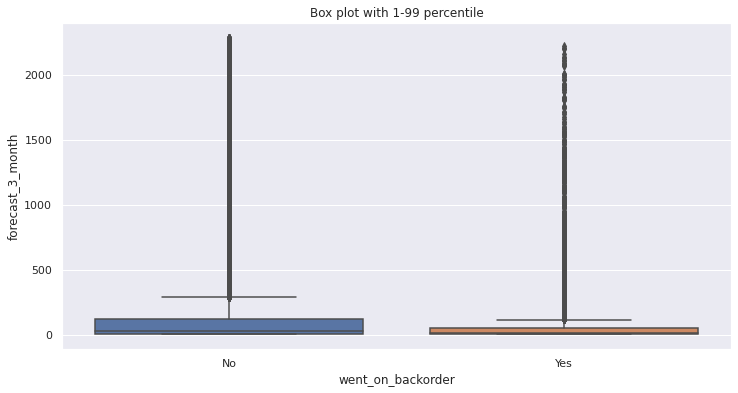

In [167]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='forecast_3_month', data=df1).set_title('Box plot with 1-99 percentile')

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

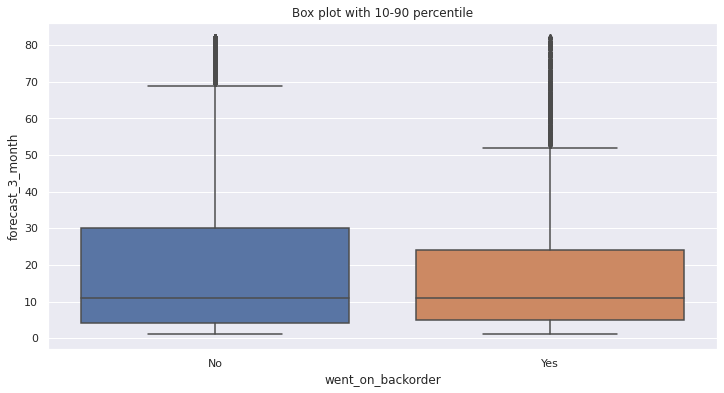

In [168]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='forecast_3_month', data=df2).set_title('Box plot with 10-90 percentile')

*   IQR of both the distribution is highly overlapping so this feature might not be useful for class seperation
*   There are outliers in both positive and negative class which can be verified from long tail of the distribution

Statistics of  forecast_6_month

In [169]:
df_train['forecast_6_month'].describe()

count    1.687860e+06
mean     3.449867e+02
std      9.795152e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.200000e+01
max      2.461360e+06
Name: forecast_6_month, dtype: float64

PDF of forecast_6_month

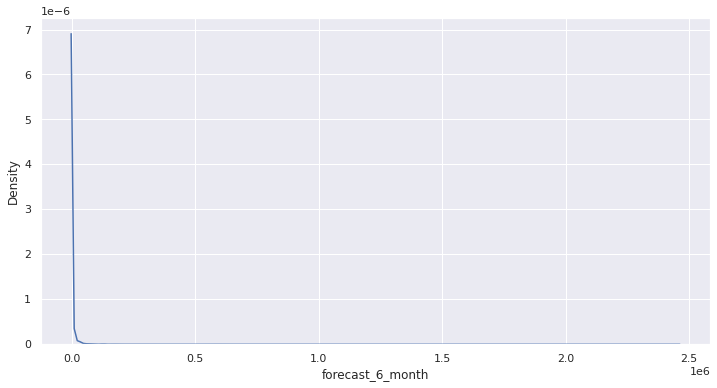

In [170]:
df_for_6mon=df_train.forecast_6_month.values
plt.figure(figsize=(12,6))
sns.kdeplot(df_for_6mon)
plt.xlabel('forecast_6_month')
plt.show()

* The plot of forecast_6_month is extremly right skewed .This can be verified from the long tail of the distribution
* It seems that there are lot of zero values for this column as can be seen from the peak at zero

Box plot of forecast_6_month

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

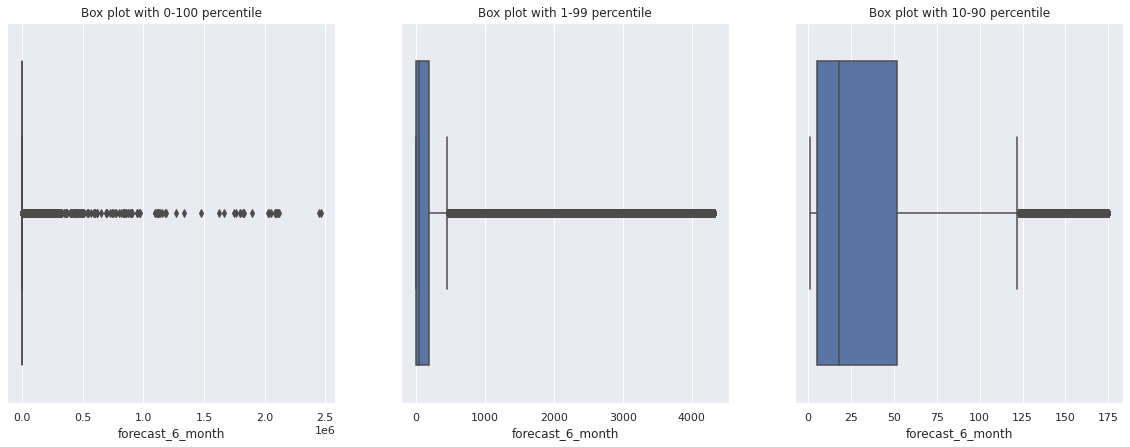

In [171]:
feature='forecast_6_month'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df_train,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

*   The plot of forecast_6_month is extremly right skewed .This can be verified from the long tail of the distribution
*   This column has outlier problem

Box plot of forecast_6_month vs went_on_backorder

Text(0.5, 1.0, 'Box plot with 0-100 percentile')

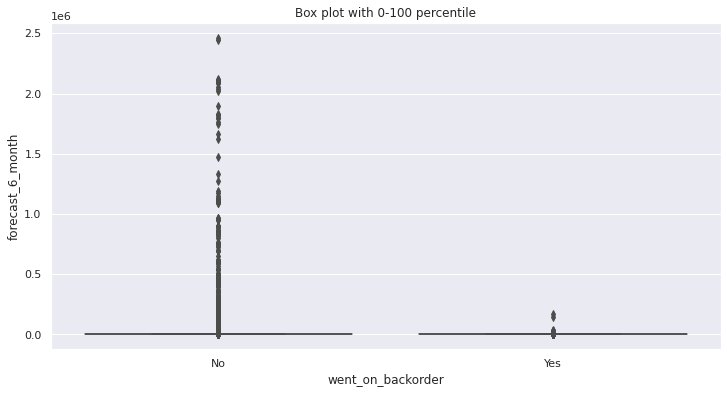

In [172]:
feature='forecast_6_month'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='forecast_6_month', data=df_train).set_title('Box plot with 0-100 percentile')

Text(0.5, 1.0, 'Box plot with 1-99 percentile')

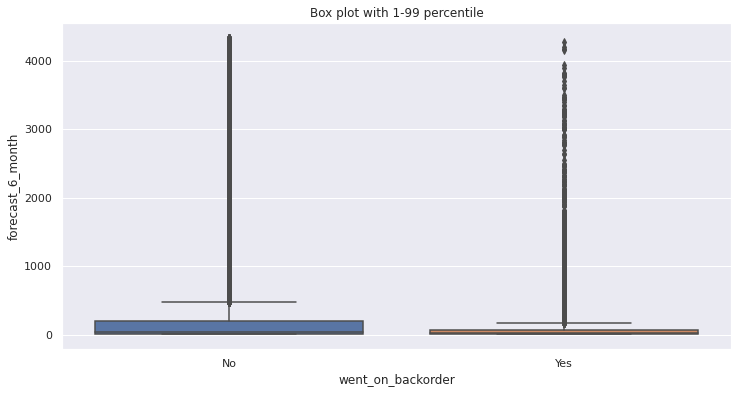

In [173]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='forecast_6_month', data=df1).set_title('Box plot with 1-99 percentile')

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

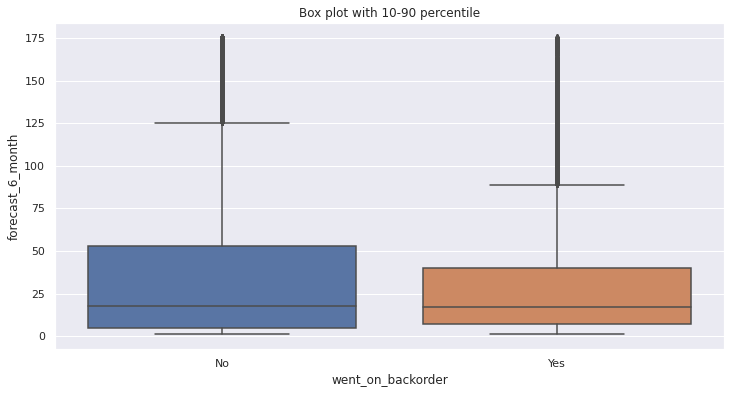

In [174]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='forecast_6_month', data=df2).set_title('Box plot with 10-90 percentile')

*   IQR of both the distribution is highly overlapping so this feature might not be useful for class seperation
*   There are outliers in both positive and negative class which can be verified from long tail of the plot

Statistics of  forecast_9_month

In [175]:
df_train['forecast_9_month'].describe()

count    1.687860e+06
mean     5.063644e+02
std      1.437892e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+01
max      3.777304e+06
Name: forecast_9_month, dtype: float64

PDF of forecast_9_month

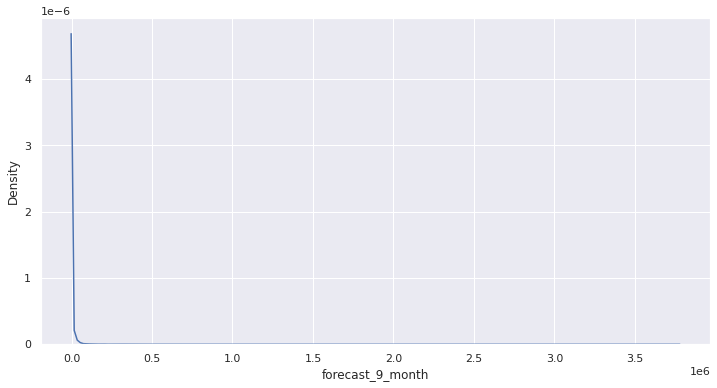

In [176]:
df_for_9mon=df_train.forecast_9_month.values
plt.figure(figsize=(12,6))
sns.kdeplot(df_for_9mon)
plt.xlabel('forecast_9_month')
plt.show()

* The plot of forecast_9_month is extremly right skewed .This can be verified from the long tail of the distribution
* It seems that there are lot of zero values for this column as can be seen from the peak at zero

Box plot of forecast_9_month

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

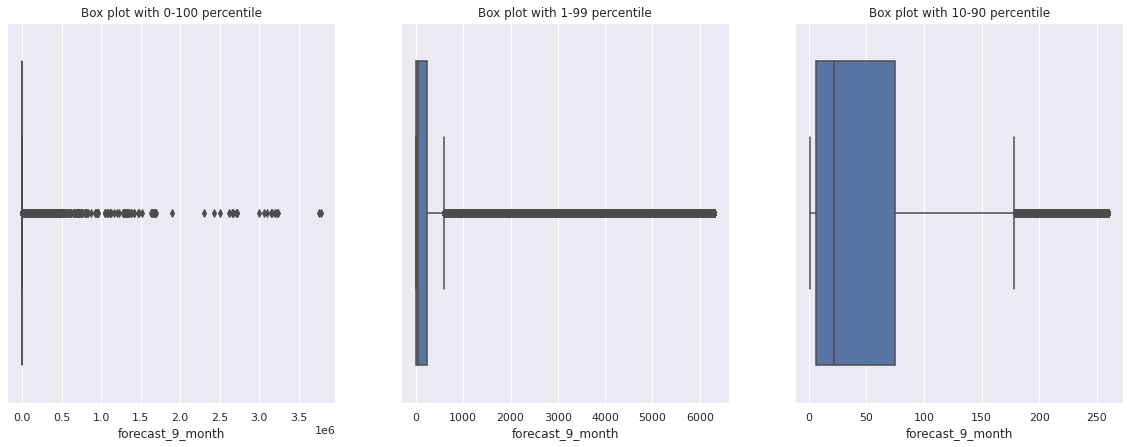

In [177]:
feature='forecast_9_month'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df_train,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

*   The plot of forecast_9_month is extremly right skewed .This can be verified from the long tail of the distribution
*   This column has outlier problem

Box plot of forecast_9_month vs went_on_backorder

Text(0.5, 1.0, 'Box plot with 0-100 percentile')

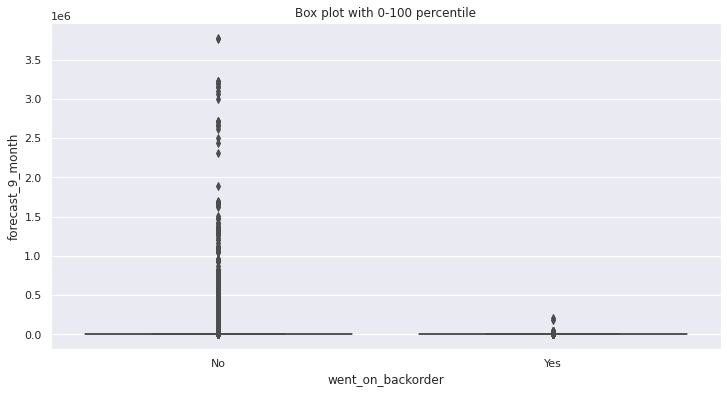

In [178]:
feature='forecast_9_month'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='forecast_9_month', data=df_train).set_title('Box plot with 0-100 percentile')

Text(0.5, 1.0, 'Box plot with 1-99 percentile')

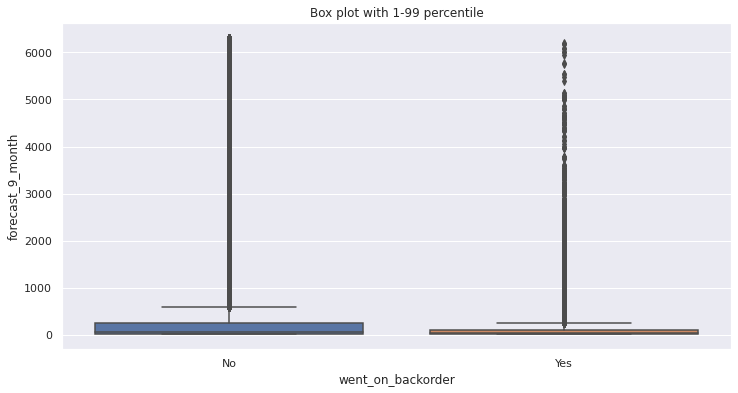

In [179]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='forecast_9_month', data=df1).set_title('Box plot with 1-99 percentile')

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

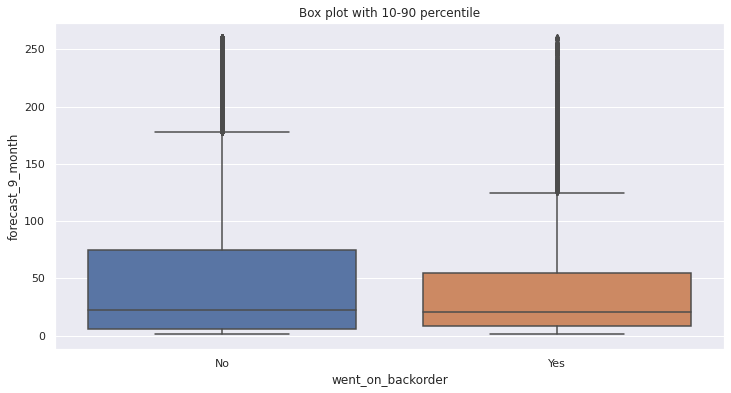

In [180]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='forecast_9_month', data=df2).set_title('Box plot with 10-90 percentile')

*   IQR of both the distribution is highly overlapping so this feature might not be useful for class seperation
*   There are outliers in both positive and negative class which can be verified from long tail of the plot

Statistics of  sales_1_month

In [181]:
df_train['sales_1_month'].describe()

count    1.687860e+06
mean     5.592607e+01
std      1.928196e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.000000e+00
max      7.417740e+05
Name: sales_1_month, dtype: float64

PDF of sales_1_month

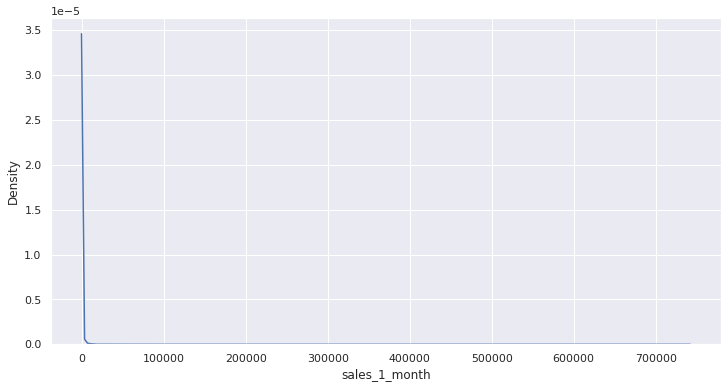

In [182]:
df_sal_1mon=df_train.sales_1_month.values
plt.figure(figsize=(12,6))
sns.kdeplot(df_sal_1mon)
plt.xlabel('sales_1_month')
plt.show()

* The plot of sales_1_month is extremly right skewed .This can be verified from the long tail of the distribution
* It seems that there are lot of zero values for this column as can be seen from the peak at zero

Box plot of sales_1_month

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

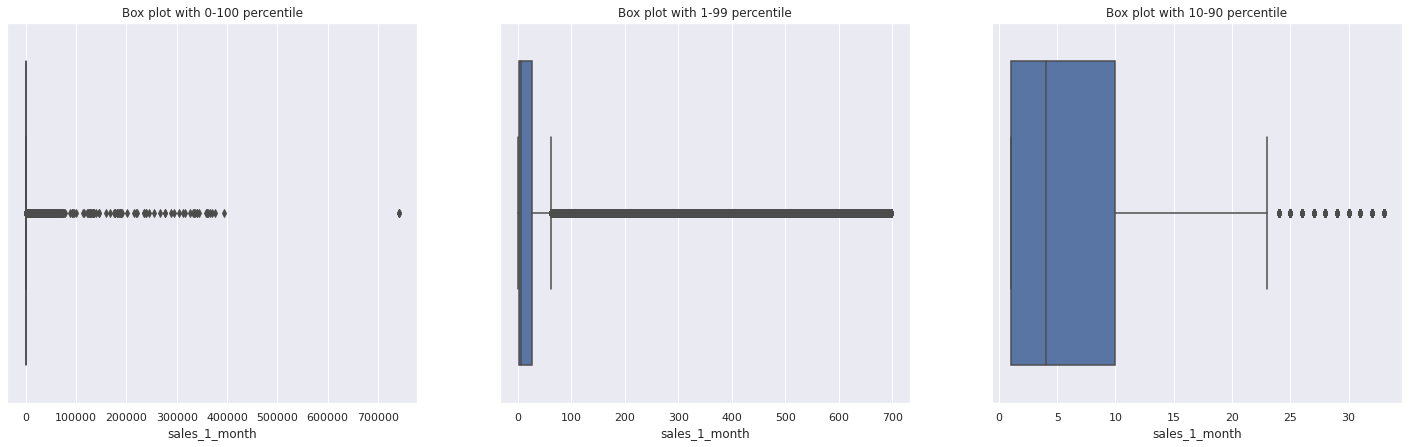

In [183]:
feature='sales_1_month'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(25,7))
sns.boxplot(x=feature, orient='v',data=df_train,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

*   The plot of sales_1_month is extremly right skewed .This can be verified from the long tail of the distribution
*   This column has outlier problem

Box plot of sales_1_month vs went_on_backorder

Text(0.5, 1.0, 'Box plot with 0-100 percentile')

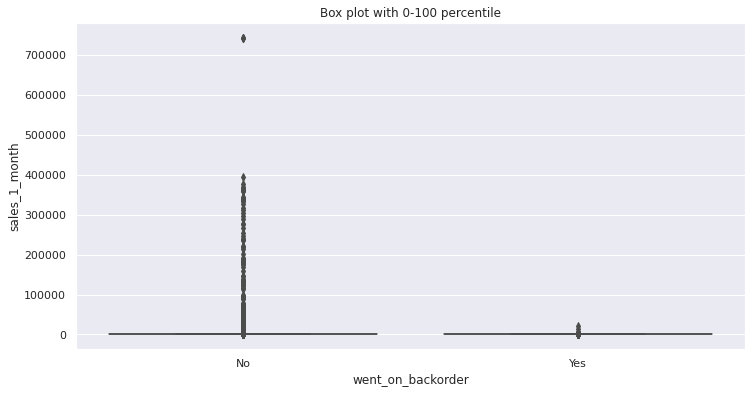

In [184]:
feature='sales_1_month'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='sales_1_month', data=df_train).set_title('Box plot with 0-100 percentile')

Text(0.5, 1.0, 'Box plot with 1-99 percentile')

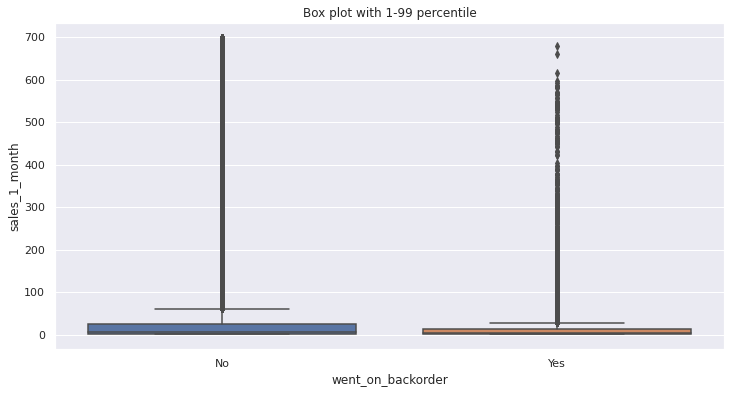

In [185]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='sales_1_month', data=df1).set_title('Box plot with 1-99 percentile')

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

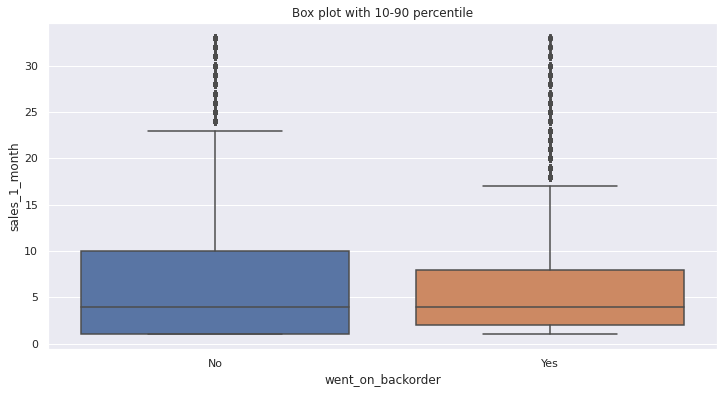

In [186]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='sales_1_month', data=df2).set_title('Box plot with 10-90 percentile')

*   IQR of both the distribution is highly overlapping so this feature might not be useful for class seperation
*   There are outliers in both positive and negative class which can be verified from long tail of the plot

Statistics of  sales_3_month

In [187]:
df_train['sales_3_month'].describe()

count    1.687860e+06
mean     1.750259e+02
std      5.192378e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.500000e+01
max      1.105478e+06
Name: sales_3_month, dtype: float64

PDF of sales_3_month

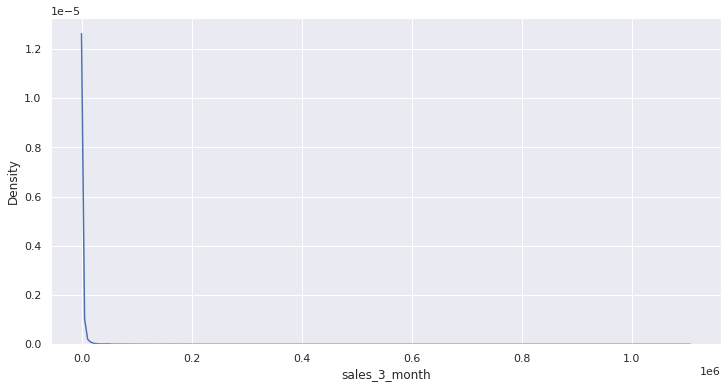

In [188]:
df_sal_3mon=df_train.sales_3_month.values
plt.figure(figsize=(12,6))
sns.kdeplot(df_sal_3mon)
plt.xlabel('sales_3_month')
plt.show()

* The plot of sales_3_month is extremly right skewed .This can be verified from the long tail of the distribution
* It seems that there are lot of zero values for this column as can be seen from the peak at zero

Box plot of sales_3_month

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

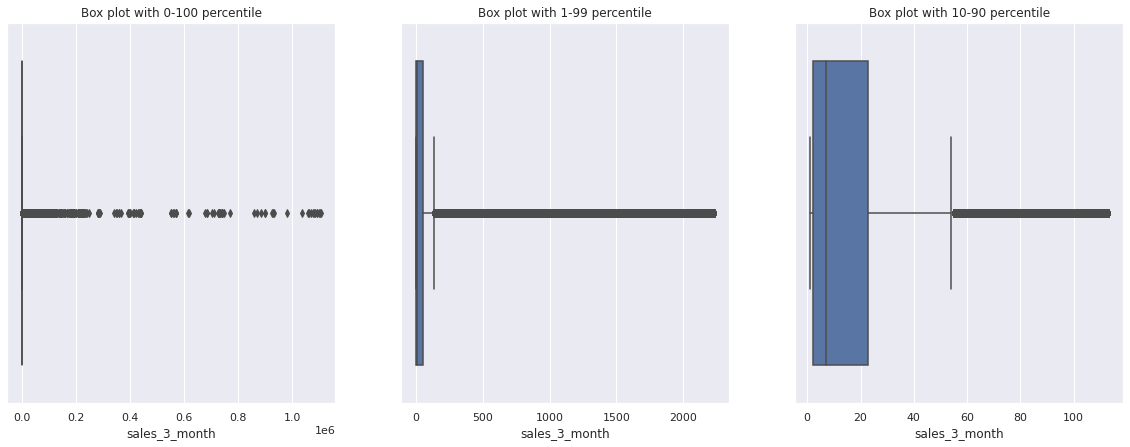

In [189]:
feature='sales_3_month'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df_train,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

*   The plot of sales_3_month is extremly right skewed .This can be verified from the long tail of the distribution
*   This column has outlier problem

Box plot of sales_3_month vs went_on_backorder

Text(0.5, 1.0, 'Box plot with 0-100 percentile')

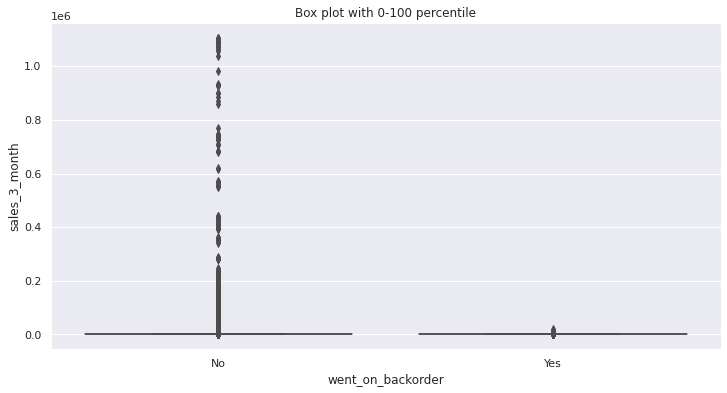

In [190]:
feature='sales_3_month'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='sales_3_month', data=df_train).set_title('Box plot with 0-100 percentile')

Text(0.5, 1.0, 'Box plot with 1-99 percentile')

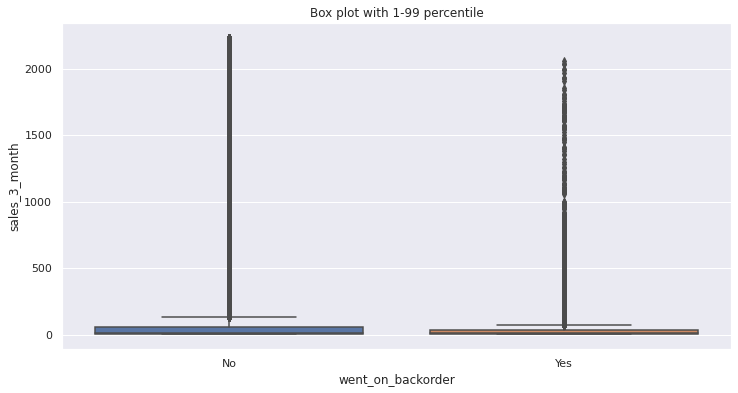

In [191]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='sales_3_month', data=df1).set_title('Box plot with 1-99 percentile')

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

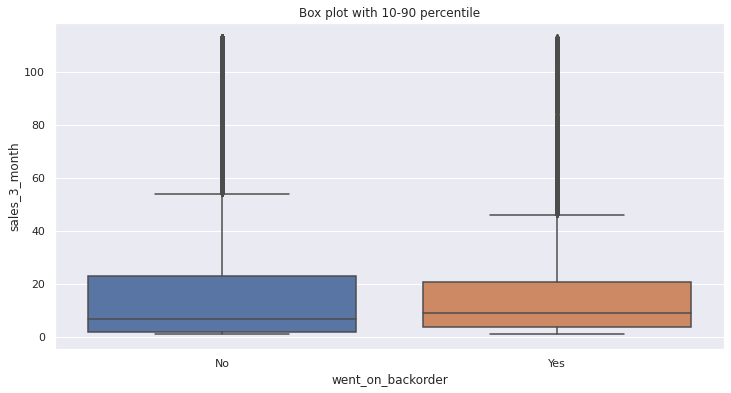

In [192]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='sales_3_month', data=df2).set_title('Box plot with 10-90 percentile')

*   IQR of both the distribution is overlapping so this feature might not be useful for class seperation
*   There are outliers in both positive and negative class which can be verified from long tail of the plot

Statistics of  sales_6_month

In [193]:
df_train['sales_6_month'].describe()

count    1.687860e+06
mean     3.417288e+02
std      9.613167e+03
min      0.000000e+00
25%      0.000000e+00
50%      2.000000e+00
75%      3.100000e+01
max      2.146625e+06
Name: sales_6_month, dtype: float64

PDF of sales_6_month

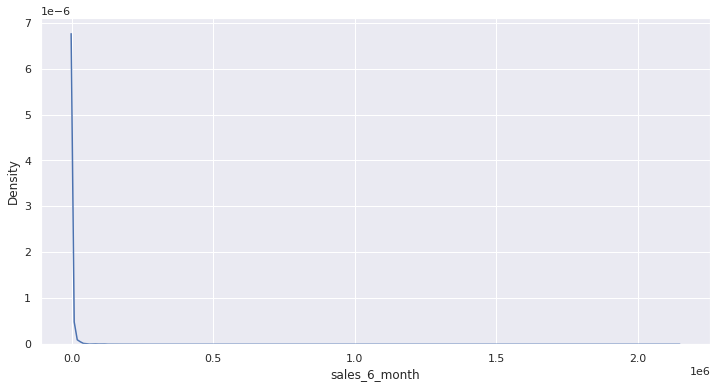

In [194]:
df_sal_6mon=df_train.sales_6_month.values
plt.figure(figsize=(12,6))
sns.kdeplot(df_sal_6mon)
plt.xlabel('sales_6_month')
plt.show()

* The plot of sales_6_month is extremly right skewed .This can be verified from the long tail of the distribution
* It seems that there are lot of zero values for this column as can be seen from the peak at zero

Box plot of sales_6_month

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

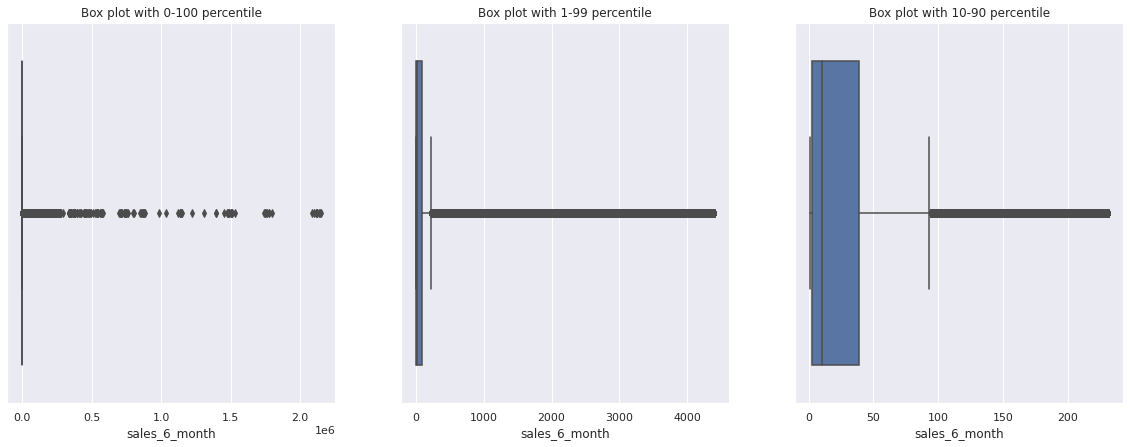

In [195]:
feature='sales_6_month'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df_train,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

*   The plot of sales_6_month is extremly right skewed .This can be verified from the long tail of the distribution
*   This column has outlier problem

Box plot of sales_6_month vs went_on_backorder

Text(0.5, 1.0, 'Box plot with 0-100 percentile')

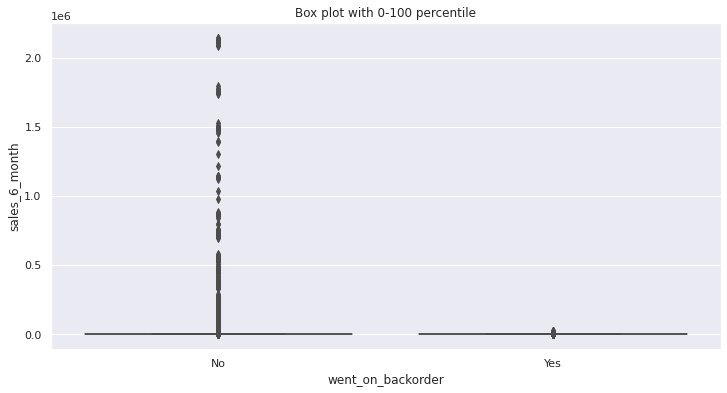

In [196]:
feature='sales_6_month'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='sales_6_month', data=df_train).set_title('Box plot with 0-100 percentile')

Text(0.5, 1.0, 'Box plot with 1-99 percentile')

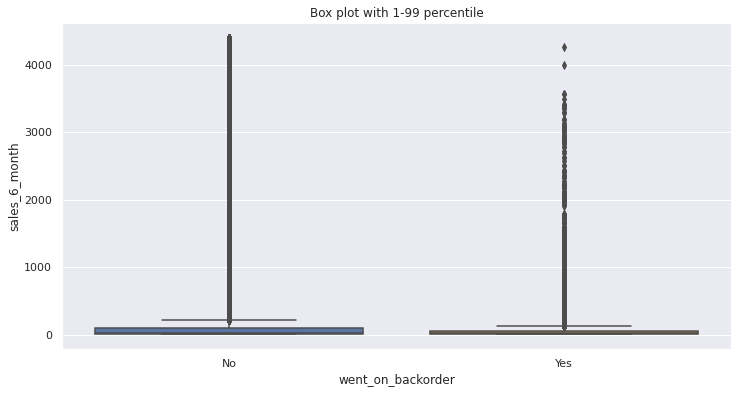

In [197]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='sales_6_month', data=df1).set_title('Box plot with 1-99 percentile')

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

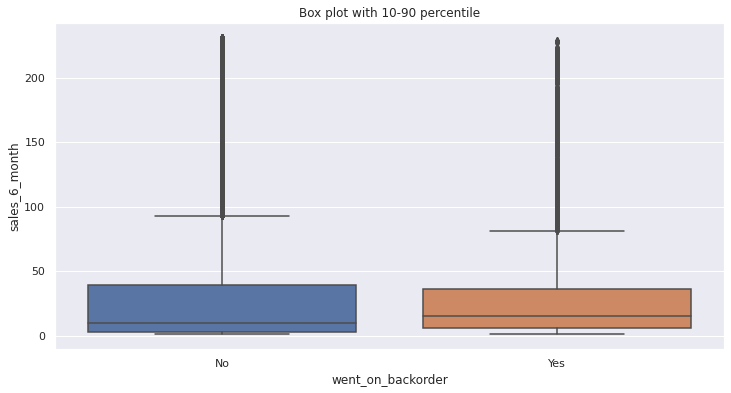

In [198]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='sales_6_month', data=df2).set_title('Box plot with 10-90 percentile')

*   IQR of both the distribution is overlapping so this feature might not be useful for class seperation
*   There are outliers in both positive and negative class which can be verified from long tail of the plot

Statistics of  sales_9_month

In [199]:
df_train['sales_9_month'].describe()

count    1.687860e+06
mean     5.252697e+02
std      1.483861e+04
min      0.000000e+00
25%      0.000000e+00
50%      4.000000e+00
75%      4.700000e+01
max      3.205172e+06
Name: sales_9_month, dtype: float64

PDF of sales_9_month

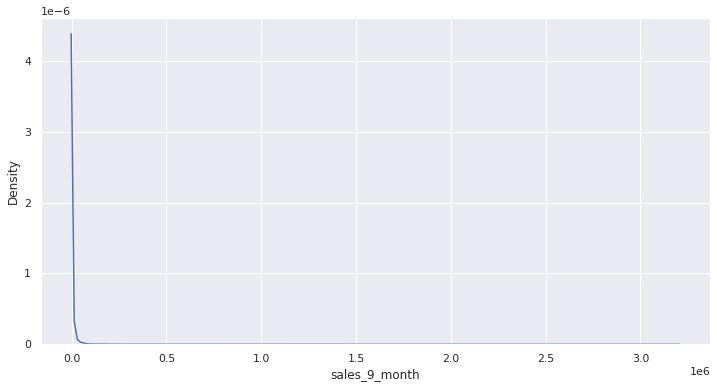

In [200]:
df_sal_9mon=df_train.sales_9_month.values
plt.figure(figsize=(12,6))
sns.kdeplot(df_sal_9mon)
plt.xlabel('sales_9_month')
plt.show()

* The plot of sales_9_month is extremly right skewed .This can be verified from the long tail of the distribution
* It seems that there are lot of zero values for this column as can be seen from the peak at zero

Box plot of sales_9_month

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

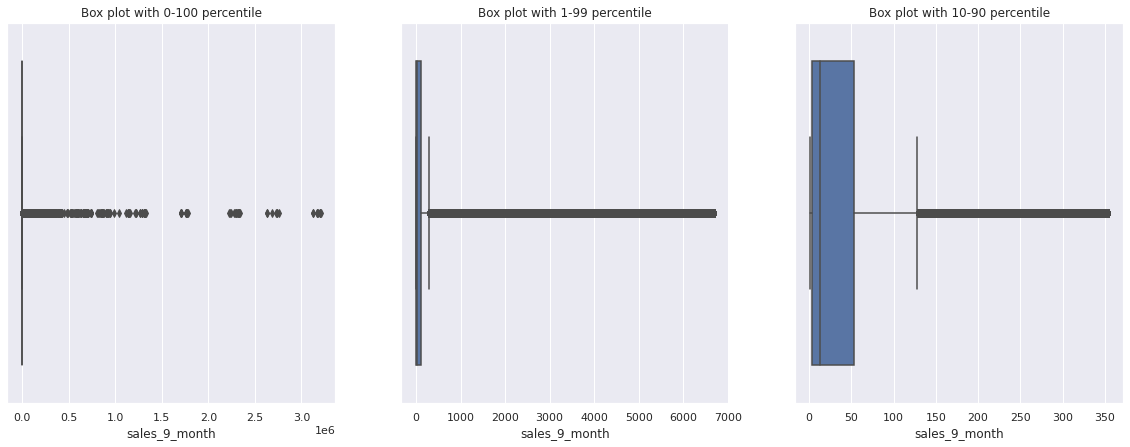

In [201]:
feature='sales_9_month'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df_train,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

*   The plot of sales_9_month is extremly right skewed .This can be verified from the long tail of the distribution
*   This column has outlier problem

Box plot of sales_9_month vs went_on_backorder

Text(0.5, 1.0, 'Box plot with 0-100 percentile')

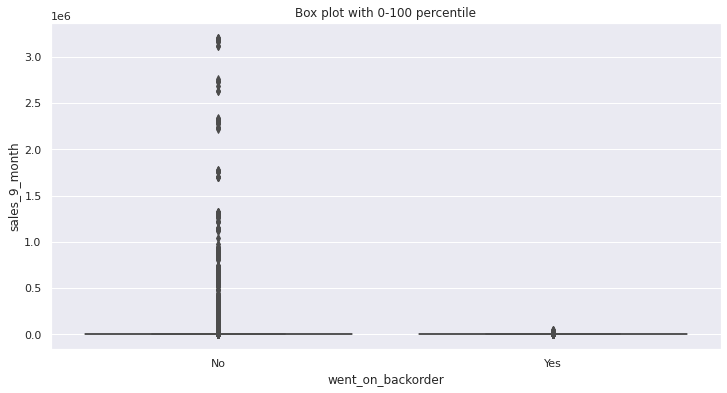

In [202]:
feature='sales_9_month'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='sales_9_month', data=df_train).set_title('Box plot with 0-100 percentile')

Text(0.5, 1.0, 'Box plot with 1-99 percentile')

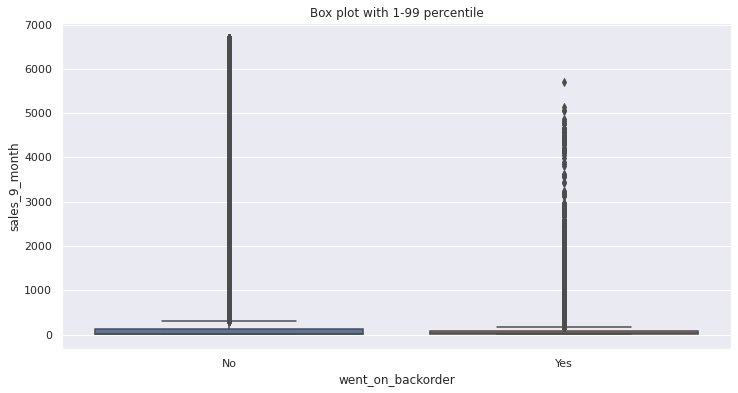

In [203]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='sales_9_month', data=df1).set_title('Box plot with 1-99 percentile')

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

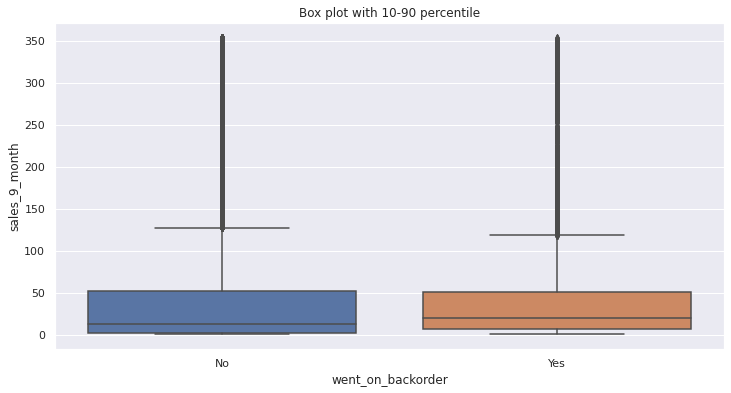

In [204]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='sales_9_month', data=df2).set_title('Box plot with 10-90 percentile')

*   IQR of both the distribution is overlapping so this feature might not be useful for class seperation
*   There are outliers in both positive and negative class which can be verified from long tail of the plot

Statistics of  min_bank

In [205]:
df_train['min_bank'].describe()

count    1.687860e+06
mean     5.277230e+01
std      1.254983e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.000000e+00
max      3.133190e+05
Name: min_bank, dtype: float64

PDF of min_bank

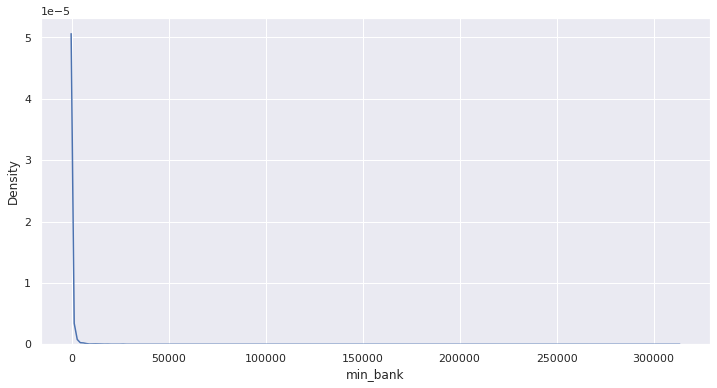

In [206]:
df_min_back=df_train.min_bank.values
plt.figure(figsize=(12,6))
sns.kdeplot(df_min_back)
plt.xlabel('min_bank')
plt.show()

* The plot of min_bank is extremly right skewed .This can be verified from the long tail of the distribution
* It seems that there are lot of zero values for this column as can be seen from the peak at zero

Box plot of min_bank

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

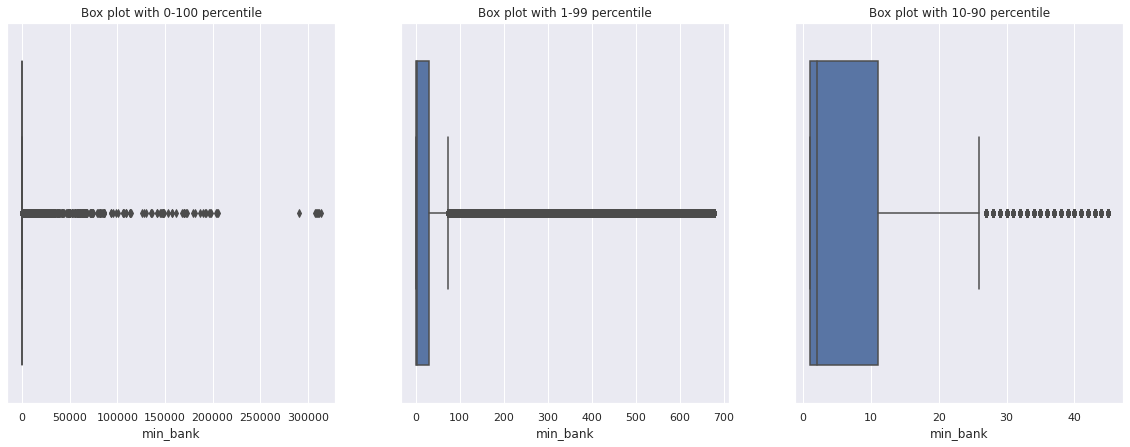

In [207]:
feature='min_bank'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df_train,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature,orient='v', data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature,orient='v', data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

*   The plot of min_bank is extremly right skewed .This can be verified from the long tail of the distribution
*   This column has outlier problem

Box plot of min_bank vs went_on_backorder

Text(0.5, 1.0, 'Box plot with 0-100 percentile')

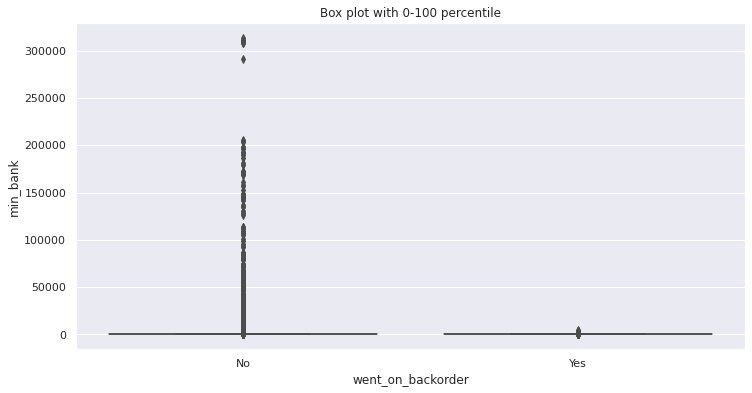

In [208]:
feature='min_bank'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='min_bank', data=df_train).set_title('Box plot with 0-100 percentile')

Text(0.5, 1.0, 'Box plot with 1-99 percentile')

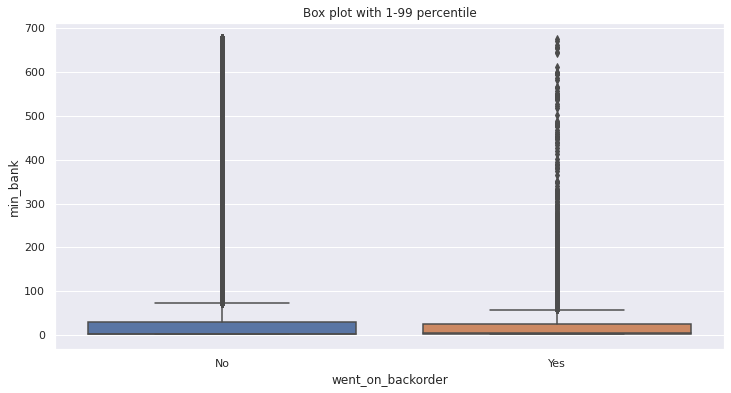

In [209]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='min_bank', data=df1).set_title('Box plot with 1-99 percentile')

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

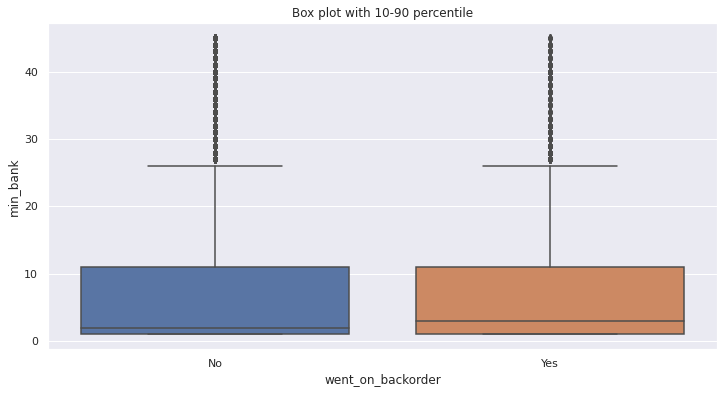

In [210]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='min_bank', data=df2).set_title('Box plot with 10-90 percentile')

*   IQR of both the distribution is highly overlapping so this feature might not be useful for class seperation
*   There are outliers in both positive and negative class which can be verified from long tail of the plot

Statistics of  pieces_past_due

In [211]:
df_train['pieces_past_due'].describe()

count    1.687860e+06
mean     2.043724e+00
std      2.360165e+02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.464960e+05
Name: pieces_past_due, dtype: float64

PDF of pieces_past_due

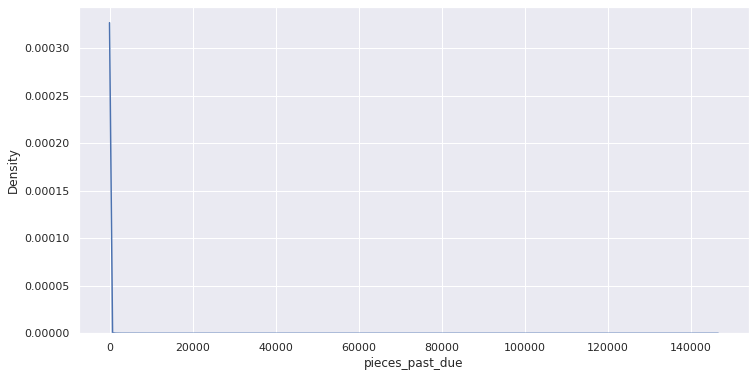

In [212]:
df_piec_pas_due=df_train.pieces_past_due.values
plt.figure(figsize=(12,6))
sns.kdeplot(df_piec_pas_due)
plt.xlabel('pieces_past_due')
plt.show()

* The plot of pieces_past_due is extremly right skewed .This can be verified from the long tail of the distribution
* It seems that there are lot of zero values for this column as can be seen from the peak at zero

Box plot of pieces_past_due

Text(0.5, 1.0, 'Box plot with 1-99 percentile')

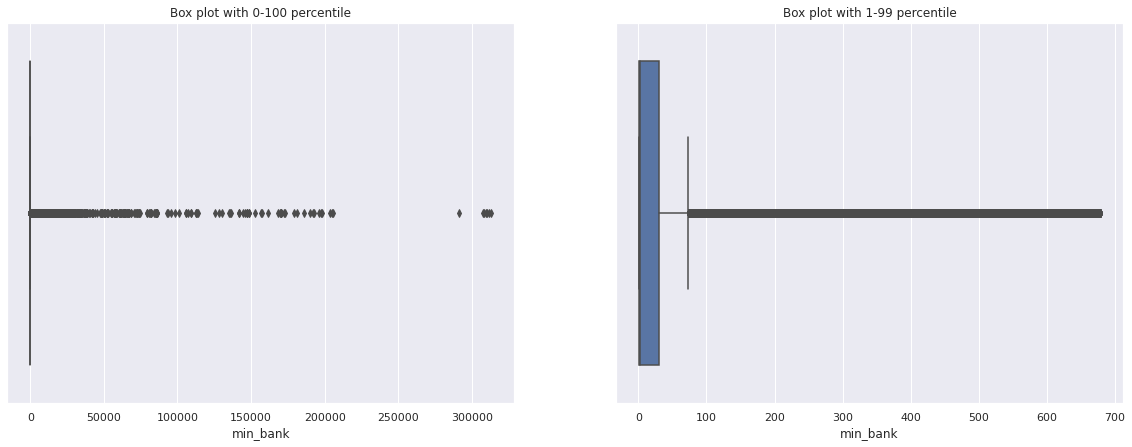

In [213]:
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
fig, axes = plt.subplots(1, 2, figsize=(20,7))
sns.boxplot(x=feature,data=df_train,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature, data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')

*   The plot of pieces_past_due is extremly right skewed .This can be verified from the long tail of the distribution
*   This column has outlier problem

Box plot of pieces_past_due vs went_on_backorder

Text(0.5, 1.0, 'Box plot with 0-100 percentile')

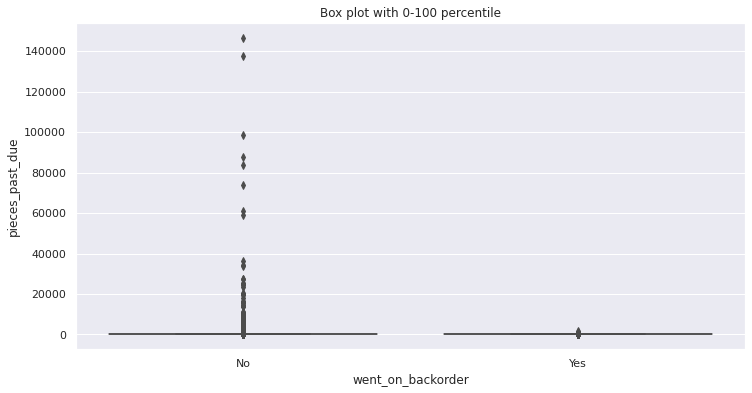

In [214]:
feature='pieces_past_due'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='pieces_past_due', data=df_train).set_title('Box plot with 0-100 percentile')

Text(0.5, 1.0, 'Box plot with 1-99 percentile')

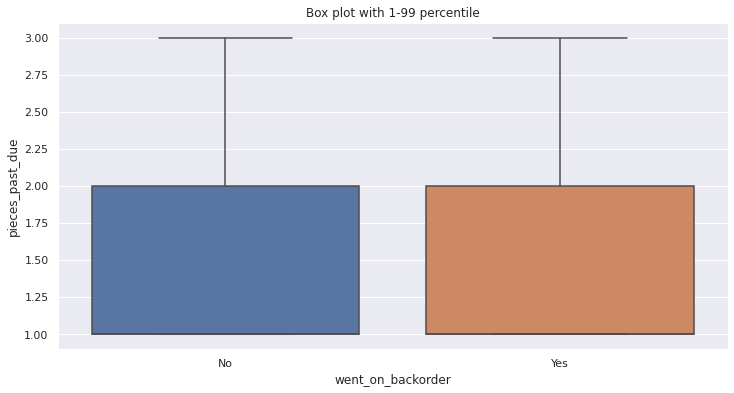

In [215]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='pieces_past_due', data=df1).set_title('Box plot with 1-99 percentile')

*   IQR of both the distribution is highly overlapping so this feature might not be useful for class seperation
*   There are outliers in both positive and negative class which can be verified from long tail of the plot

Statistics of  perf_6_month_avg

In [216]:
df_train['perf_6_month_avg'].describe()

count    1.687860e+06
mean    -6.872059e+00
std      2.655636e+01
min     -9.900000e+01
25%      6.300000e-01
50%      8.200000e-01
75%      9.700000e-01
max      1.000000e+00
Name: perf_6_month_avg, dtype: float64

PDF of perf_6_month_avg

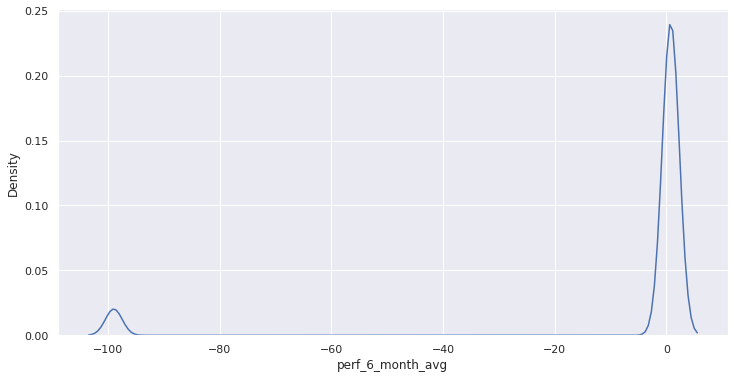

In [217]:
df_perf_6mon=df_train.perf_6_month_avg.values
plt.figure(figsize=(12,6))
sns.kdeplot(df_perf_6mon)
plt.xlabel('perf_6_month_avg')
plt.show()

* The plot of perf_6_month_avg is extremly left skewed .This can be verified from the long tail of the distribution on left side
* There are lot of negative values present for this column

Box plot of perf_6_month_avg

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

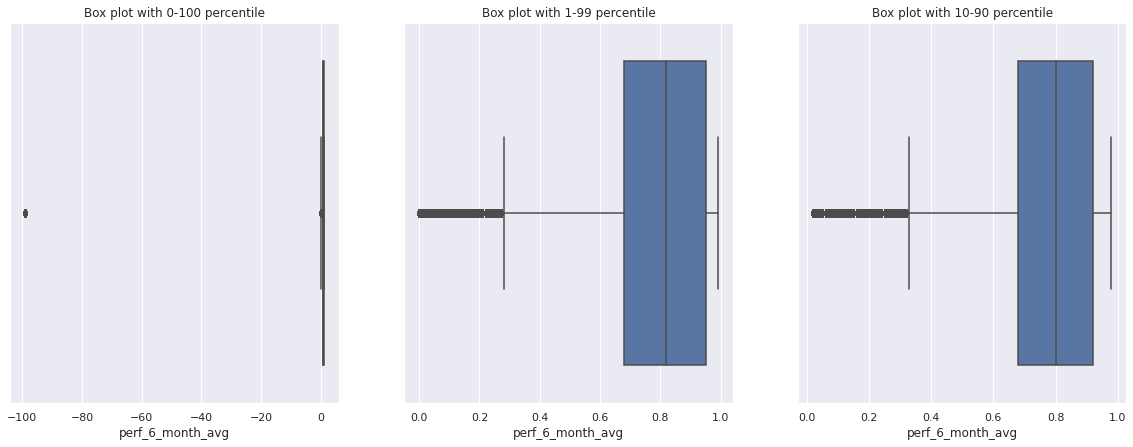

In [218]:
feature='perf_6_month_avg'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, data=df_train,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature, data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature, data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

*   The plot of perf_6_month_avg is extremly left skewed .This can be verified from the long tail of the distribution on left side
*   This column has outlier problem

Box plot of perf_6_month_avg vs went_on_backorder

Text(0.5, 1.0, 'Box plot with 0-100 percentile')

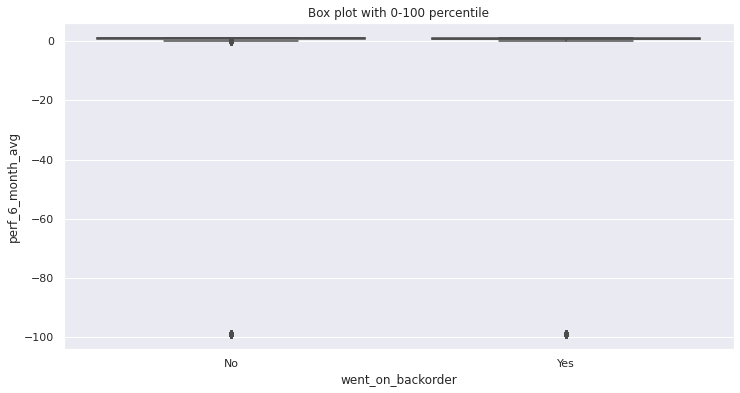

In [219]:
feature='perf_6_month_avg'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='perf_6_month_avg', data=df_train).set_title('Box plot with 0-100 percentile')

Text(0.5, 1.0, 'Box plot with 1-99 percentile')

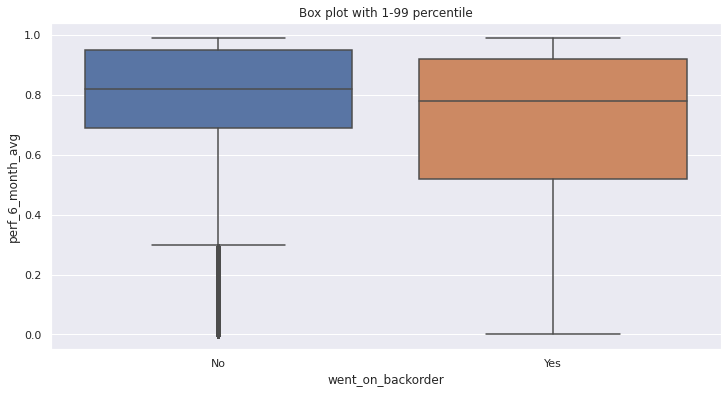

In [220]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='perf_6_month_avg', data=df1).set_title('Box plot with 1-99 percentile')

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

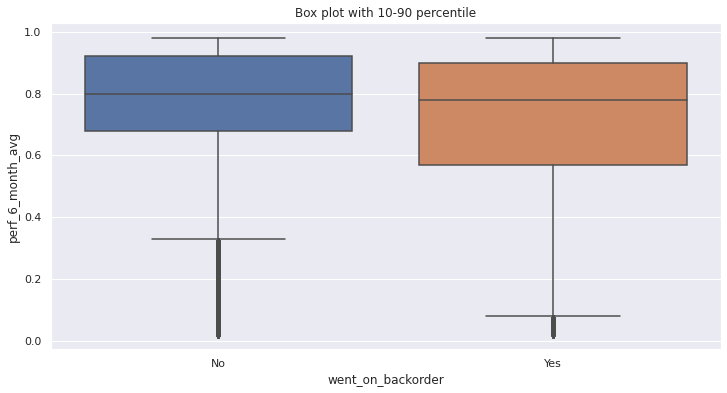

In [221]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='perf_6_month_avg', data=df2).set_title('Box plot with 10-90 percentile')

*   IQR of both the distribution is less overlapping so this feature might be useful for class seperation
*   There are outliers in both positive and negative class which can be verified from long tail of the plot

Statistics of perf_12_month_avg

In [222]:
df_train['perf_12_month_avg'].describe()

count    1.687860e+06
mean    -6.437947e+00
std      2.584333e+01
min     -9.900000e+01
25%      6.600000e-01
50%      8.100000e-01
75%      9.500000e-01
max      1.000000e+00
Name: perf_12_month_avg, dtype: float64

PDF of perf_12_month_avg

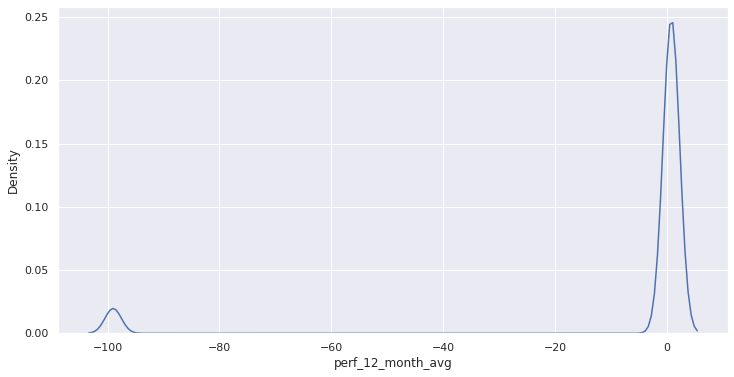

In [223]:
df_perf_12mon=df_train.perf_12_month_avg.values
plt.figure(figsize=(12,6))
sns.kdeplot(df_perf_12mon)
plt.xlabel('perf_12_month_avg')
plt.show()

* The plot of perf_12_month_avg is extremly left skewed .This can be verified from the long tail of the distribution on left side
* There are lot of negative values present for this column

Box plot of perf_12_month_avg

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

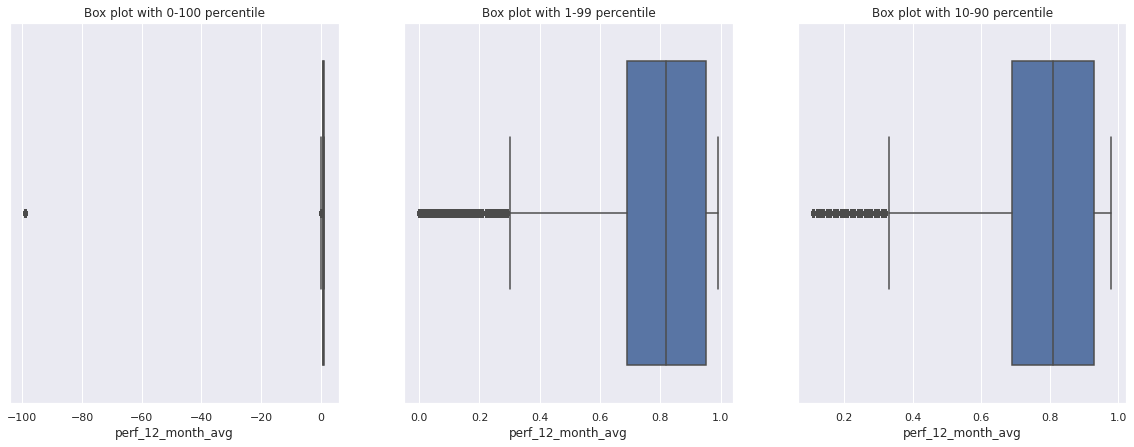

In [224]:
feature='perf_12_month_avg'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
fig, axes = plt.subplots(1, 3, figsize=(20,7))
sns.boxplot(x=feature, data=df_train,ax=axes[0]).set_title('Box plot with 0-100 percentile')
sns.boxplot(x=feature, data=df1,ax=axes[1]).set_title('Box plot with 1-99 percentile')
sns.boxplot(x=feature, data=df2,ax=axes[2]).set_title('Box plot with 10-90 percentile')

*   The plot of perf_12_month_avg is extremly left skewed .This can be verified from the long tail of the distribution
*   This column has outlier problem

Box plot of perf_12_month_avg vs went_on_backorder

Text(0.5, 1.0, 'Box plot with 0-100 percentile')

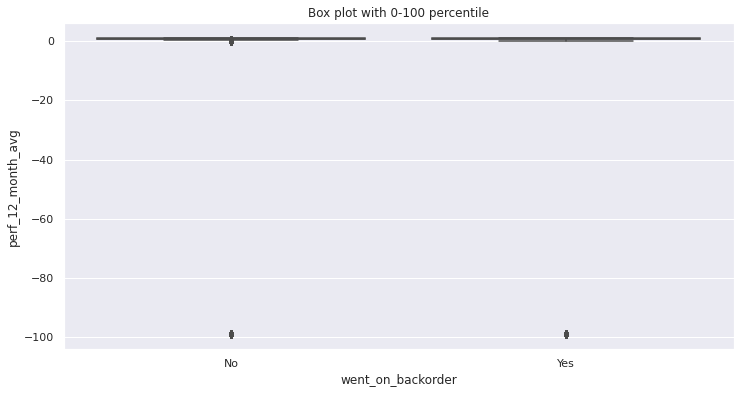

In [225]:
feature='perf_12_month_avg'
df1= per_dataframe(df_train,feature,0.01,0.99)
df2= per_dataframe(df_train,feature,0.1,0.90)
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='perf_12_month_avg', data=df_train).set_title('Box plot with 0-100 percentile')

Text(0.5, 1.0, 'Box plot with 1-99 percentile')

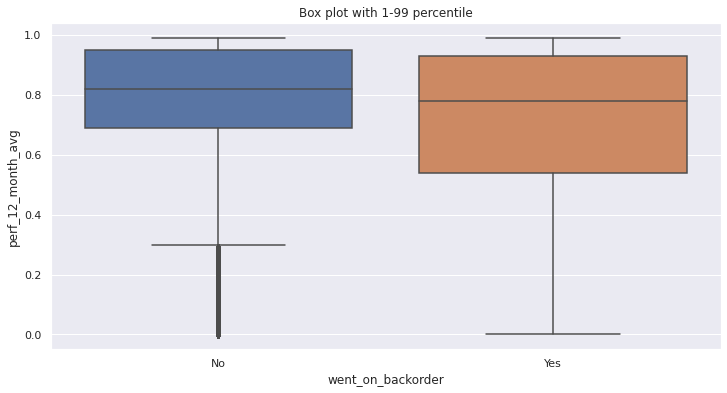

In [226]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='perf_12_month_avg', data=df1).set_title('Box plot with 1-99 percentile')

Text(0.5, 1.0, 'Box plot with 10-90 percentile')

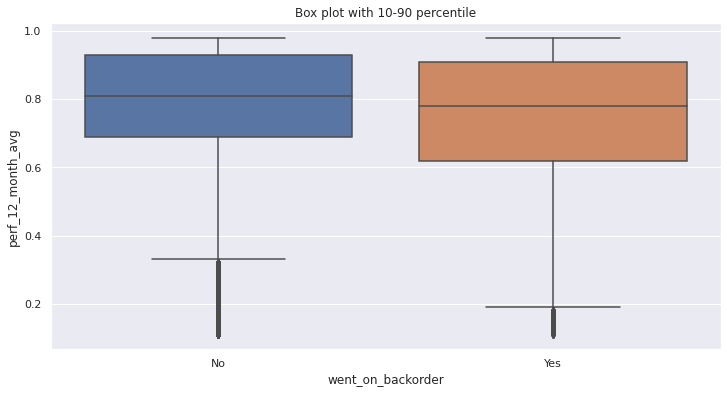

In [227]:
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='perf_12_month_avg', data=df2).set_title('Box plot with 10-90 percentile')

*   IQR of both the distribution is less overlapping so this feature might be useful for class seperation
*   There are outliers in both positive and negative class which can be verified from long tail of the plot

Statistics of local_bo_qty

In [228]:
df_train['local_bo_qty'].describe()

count    1.687860e+06
mean     6.264507e-01
std      3.372224e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.253000e+04
Name: local_bo_qty, dtype: float64

PDF of local_bo_qty

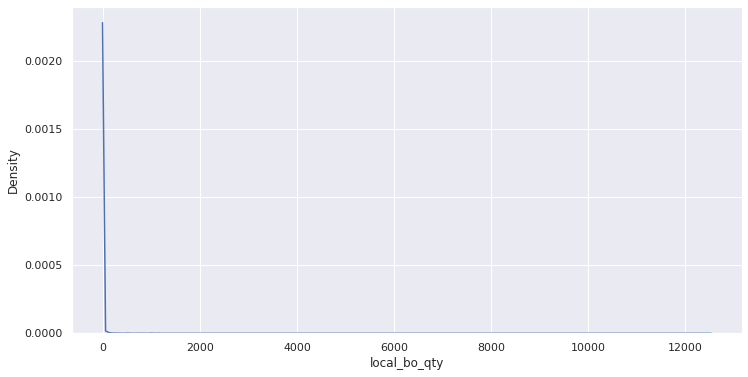

In [229]:
df_local_bo_qty=df_train.local_bo_qty.values
plt.figure(figsize=(12,6))
sns.kdeplot(df_local_bo_qty)
plt.xlabel('local_bo_qty')
plt.show()

Box plot of local_bo_qty

Text(0.5, 1.0, 'Box plot with 0-100 percentile')

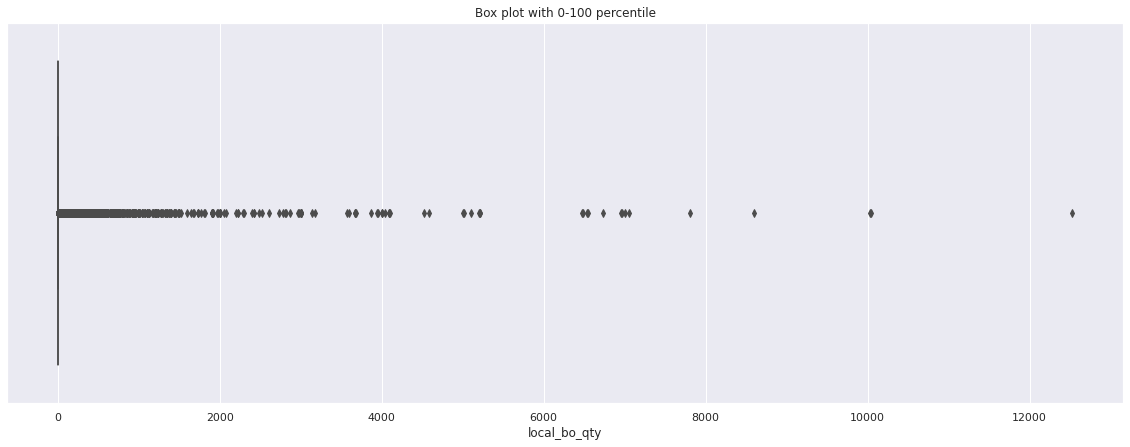

In [230]:
feature='local_bo_qty'
df1= per_dataframe(df_train,feature,0.01,0.99)
fig, axes = plt.subplots(1, 1, figsize=(20,7))
sns.boxplot(x=feature, orient='v',data=df_train).set_title('Box plot with 0-100 percentile')

*   The plot of local_bo_qty is extremly right skewed .This can be verified from the long tail of the distribution
*   This column has outlier problem
*   IQR range is very small

Box plot of local_bo_qty vs went_on_backorder

Text(0.5, 1.0, 'Box plot with 0-100 percentile')

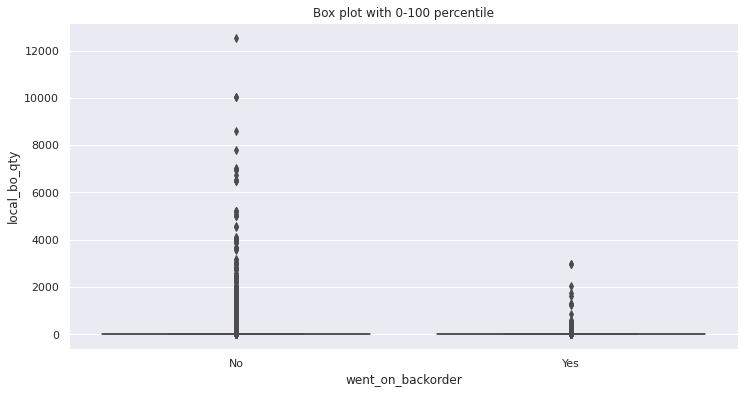

In [231]:
feature='local_bo_qty'
df1= per_dataframe(df_train,feature,0.01,0.99)
plt.figure(figsize=(12,6))
sns.boxplot(x='went_on_backorder',y='local_bo_qty', data=df_train).set_title('Box plot with 0-100 percentile')

*   IQR seem to be similiar hence cannot differentiate between classes
*   There are outliers in both positive and negative class which can be verified from long tail of the plot

### 2.5.2 Correlation plot of numerical features

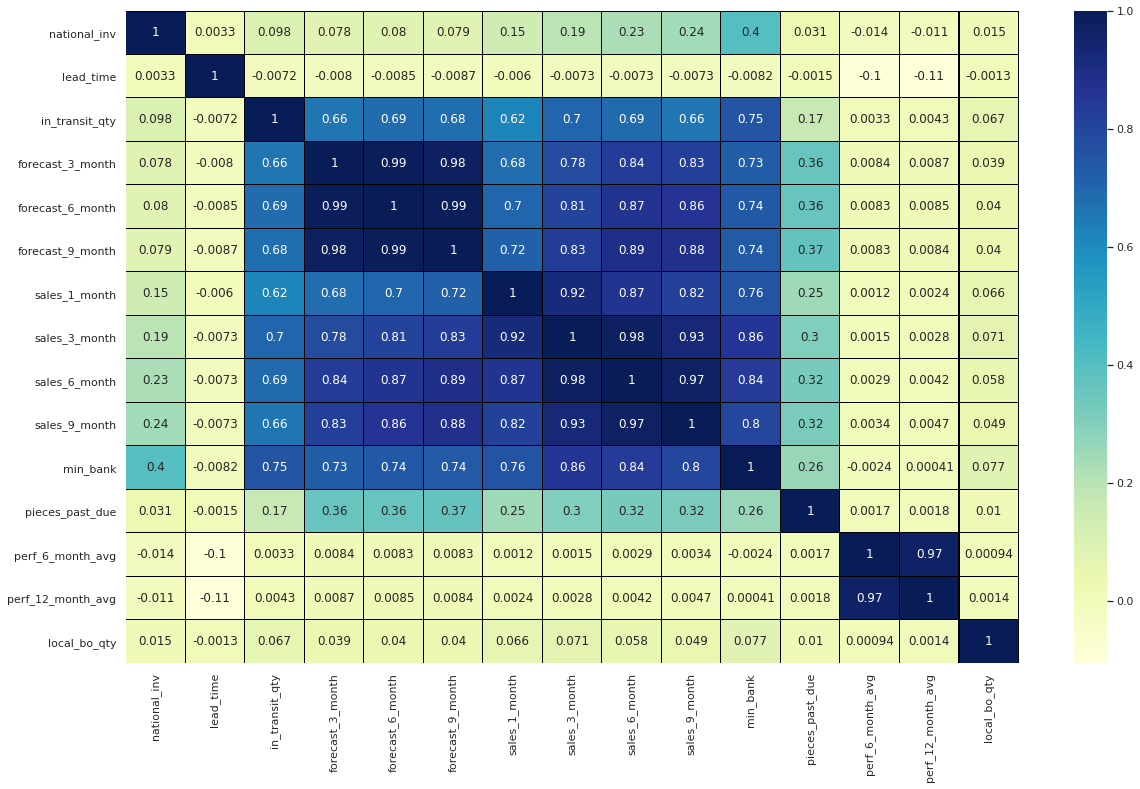

In [232]:
#Plot correlation matrix for numerical features

df_train_num_feat=df_train.select_dtypes(include='number')
df_train_num_feat_corr=df_train_num_feat.corr()
sns.set(rc={'figure.figsize':(20,12)})
sns.heatmap(df_train_num_feat_corr,xticklabels=df_train_num_feat_corr.columns,yticklabels=df_train_num_feat_corr.columns,cmap="YlGnBu",linecolor="black",linewidths=0.05,annot=True)

* Sales columns are very much correlated with each other
* Forecast columns are very much correlated with each other
* Performance columns are very much correlated with each other
* national_inv has weak correlation with the other features 
* min_bank has high correlation with in_transit_qty which means that greater minimum amount in stock will lead to increase in quantity to be shipped
* min_bank has high correlation with sales and forecast columns which suggest greater minimum amount of stock is recommended when the sales and forecast are high
* Sales and forecast columns have high correlation which suggest that if the sales have been high in previous months the forecast sales is also like to increase
* lead_time has a negative weak correlation with the rest of columns which suggest that increase in lead_time is likely to have a negative impact in sales and perfomance
* in_transit_qty has strong correlation with forecast and sales columns and weak with the rest of the columns.This is true since more forecast and sales means more quantity is to be shipped to inventory
* local_bo_qty has negligible correlation with other columns

In [233]:
# Print Top most correlated features

#Code taken from https://www.kaggle.com/sharmasanthosh/exploratory-study-on-ml-algorithms

size=15
threshold = 0.5

# List of pairs along with correlation above threshold
df_train_num_feat_th_list = []
columns=df_train_num_feat_corr.columns

#Search for the highly correlated pairs
for i in range(0,size): 
    for j in range(i+1,size): 
      p=df_train_num_feat_corr.iloc[i,j]
      if (p >= threshold and p < 1) or (p < 0 and p <= -threshold):
        df_train_num_feat_th_list.append([p,i,j])

#Sort to show higher ones first            
sort_corr_list = sorted(df_train_num_feat_th_list,key=lambda x: abs(x[0]),reverse=True)

#Print correlations and column names
for val,ind,col in sort_corr_list:
    print ("%s and %s = %.2f" % (columns[ind],columns[col],val))

forecast_6_month and forecast_9_month = 0.99
forecast_3_month and forecast_6_month = 0.99
forecast_3_month and forecast_9_month = 0.98
sales_3_month and sales_6_month = 0.98
sales_6_month and sales_9_month = 0.97
perf_6_month_avg and perf_12_month_avg = 0.97
sales_3_month and sales_9_month = 0.93
sales_1_month and sales_3_month = 0.92
forecast_9_month and sales_6_month = 0.89
forecast_9_month and sales_9_month = 0.88
forecast_6_month and sales_6_month = 0.87
sales_1_month and sales_6_month = 0.87
forecast_6_month and sales_9_month = 0.86
sales_3_month and min_bank = 0.86
sales_6_month and min_bank = 0.84
forecast_3_month and sales_6_month = 0.84
forecast_9_month and sales_3_month = 0.83
forecast_3_month and sales_9_month = 0.83
sales_1_month and sales_9_month = 0.82
forecast_6_month and sales_3_month = 0.81
sales_9_month and min_bank = 0.80
forecast_3_month and sales_3_month = 0.78
sales_1_month and min_bank = 0.76
in_transit_qty and min_bank = 0.75
forecast_6_month and min_bank = 0.74

### 2.5.2 Univariate analysis of categorical features

In [234]:
# Count of each category in potential_issue

df_train.potential_issue.value_counts()

No     1686953
Yes        907
Name: potential_issue, dtype: int64

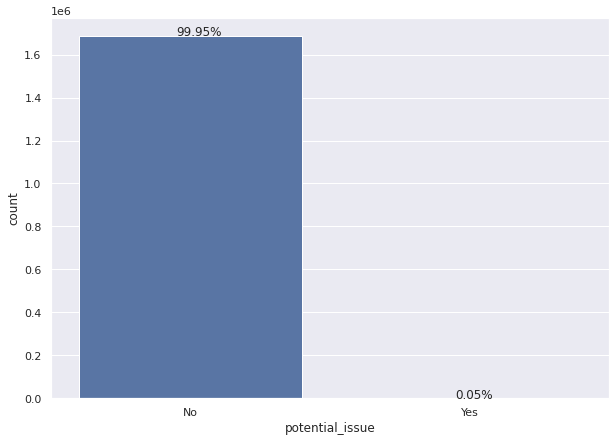

In [235]:
# Count plot of potential_issue

feature='potential_issue'
plt.figure(figsize=(10,7))
plt.xlabel(feature,size=12)
plt.ylabel('count',size=12)
ax=sns.countplot(x=feature, data=df_train) 
per_annot(df_train,feature) 


* 99.95% potential_issue is flagged as "No" and 0.05% is flagged as "Yes" which suggest there is high imbalance in distribution of feature

went_on_backorder         No       Yes
potential_issue                       
No                 99.333591  0.666409
Yes                94.377067  5.622933


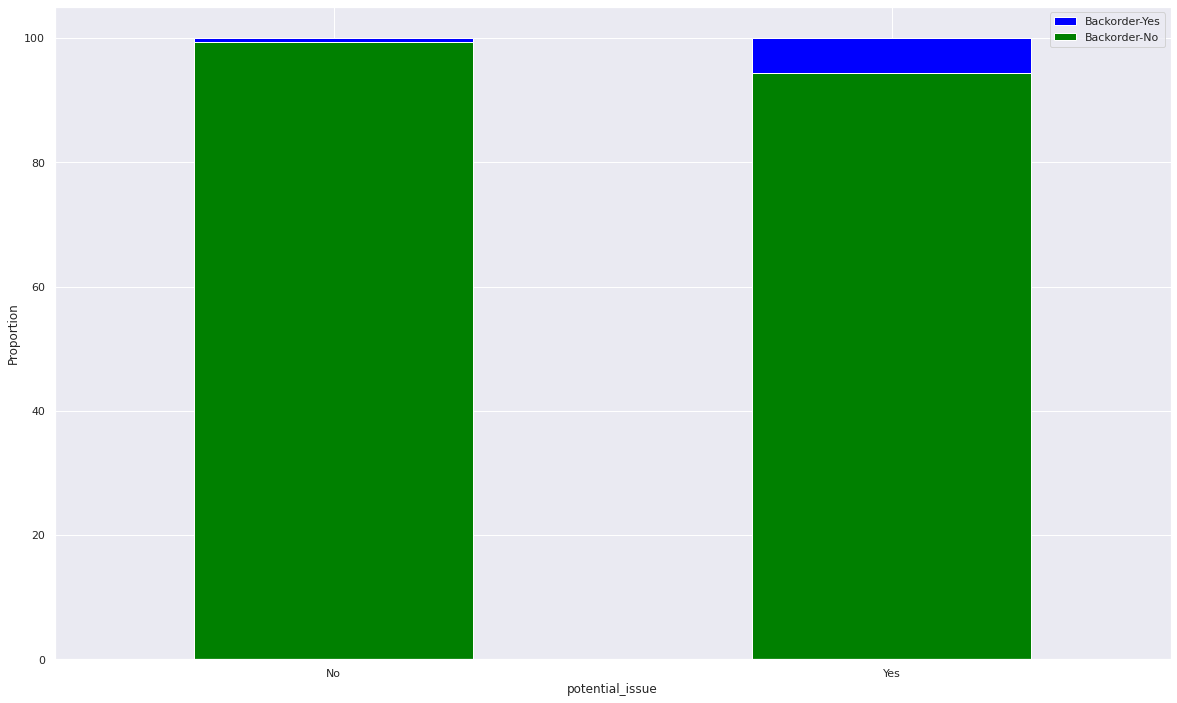

In [236]:
#Bar Plot for potential_issue vs went_on_backorder

feature='potential_issue'
target_variable="went_on_backorder"
categorical_plot(feature,target_variable)

* When the potential issue is "Yes" , 5.6 % products went to backorder
* When the potential issue is "No" , 0.7 % products went to backorder
* When the potential issue is "Yes" there is 8 times more probability that the product went to backorder

In [237]:
# Count of each category in deck_risk

df_train.deck_risk.value_counts()


No     1300377
Yes     387483
Name: deck_risk, dtype: int64

* There is imbalance in the distribution of points

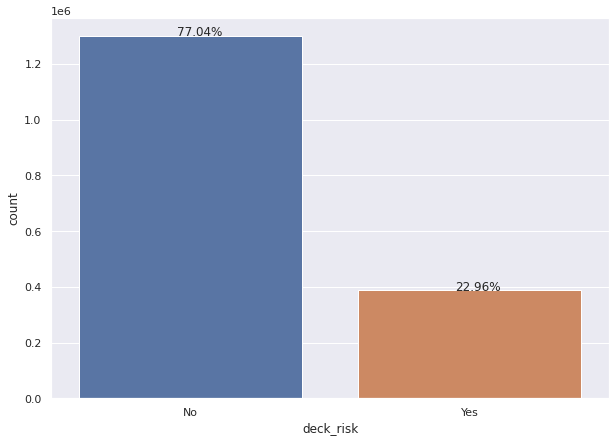

In [238]:
# Count plot of deck_risk

feature='deck_risk'
plt.figure(figsize=(10,7))
plt.xlabel(feature,size=12)
plt.ylabel('count',size=12)
ax=sns.countplot(x=feature, data=df_train) 
per_annot(df_train,feature)

* 77.04% potential_issue is flagged as "No" and 22.96% is flagged as "Yes" which suggest there is high imbalance in distribution of feature

went_on_backorder         No       Yes
deck_risk                             
No                 99.278901  0.721099
Yes                99.505527  0.494473


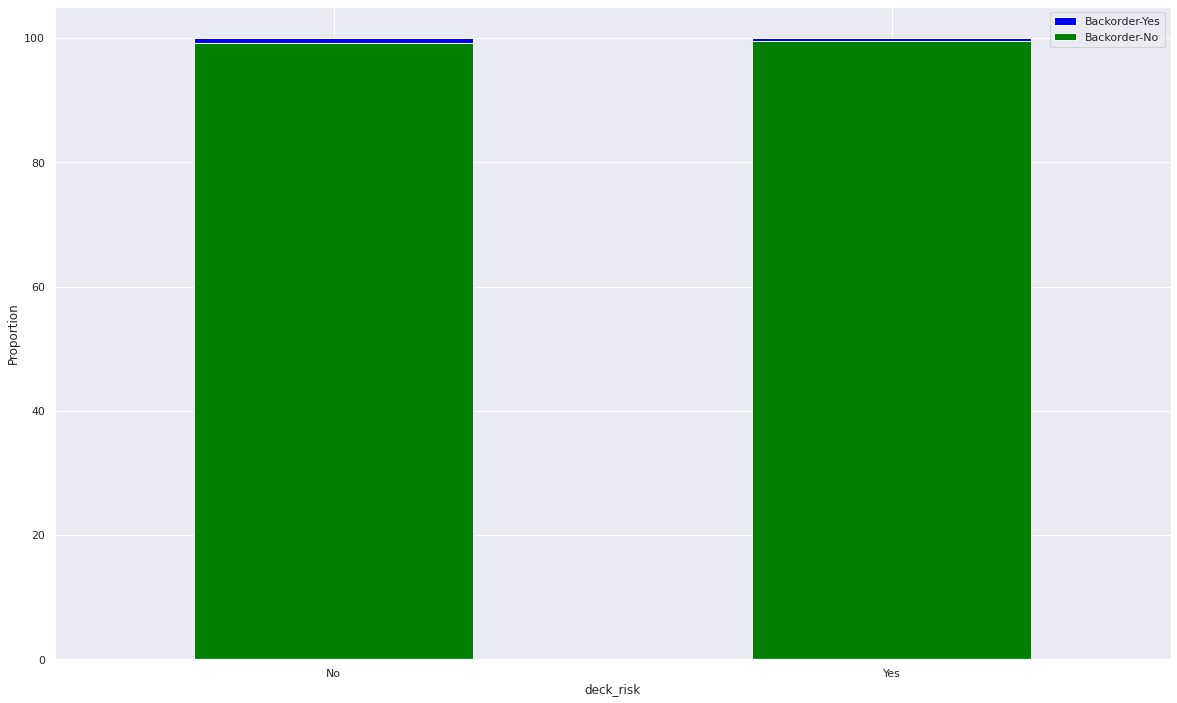

In [239]:
#Bar Plot for deck_risk vs went_on_backorder

feature='deck_risk'
target_variable="went_on_backorder"
categorical_plot(feature,target_variable)

* When the deck_risk  is "Yes" , 0.5 % products went to backorder
* When the deck_risk  is "No" , 0.7 % products went to backorder
* Since the distribution is almost similiar this feature do not seem to have impact on the backorders

In [240]:
# Count of each category in oe_constraint

df_train.oe_constraint.value_counts()

No     1687615
Yes        245
Name: oe_constraint, dtype: int64

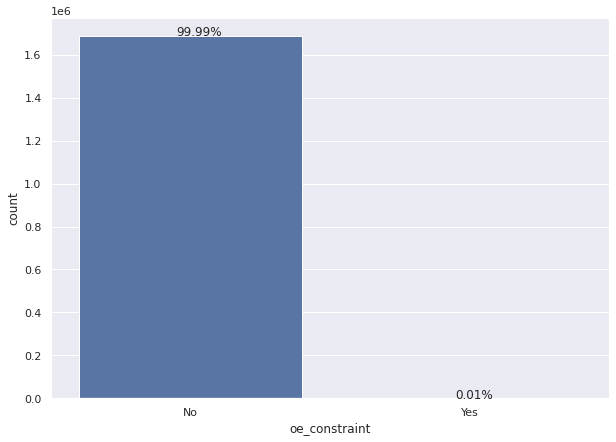

In [241]:
# Count plot of oe_constraint

feature='oe_constraint'
plt.figure(figsize=(10,7))
plt.xlabel(feature,size=12)
plt.ylabel('count',size=12)
ax=sns.countplot(x=feature, data=df_train) 
per_annot(df_train,feature)


* 99.99% potential_issue is flagged as "No" and 0.01% is flagged as "Yes" which suggest there is high imbalance in distribution of feature

went_on_backorder         No       Yes
oe_constraint                         
No                 99.331305  0.668695
Yes                96.734694  3.265306


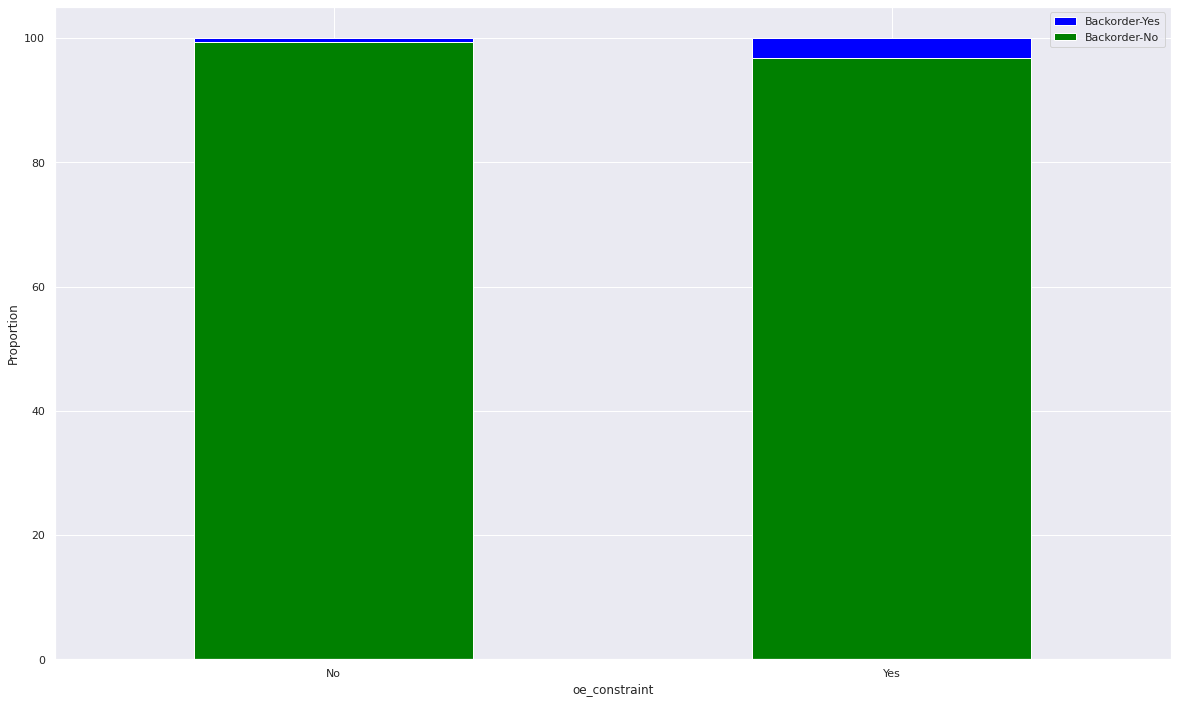

In [242]:
#Bar Plot for oe_constraint vs went_on_backorder

feature='oe_constraint'
target_variable="went_on_backorder"
categorical_plot(feature,target_variable)


* When the oe_constraint  is "Yes" , 3% products went to backorder
* When the oe_constraint  is "No" , 0.7 % products went to backorder
* When the oe_constraint is "Yes" there is 3 times more probability that the product went to backorder

In [243]:
# Count of each category in ppap_risk

df_train.ppap_risk.value_counts()

No     1484026
Yes     203834
Name: ppap_risk, dtype: int64

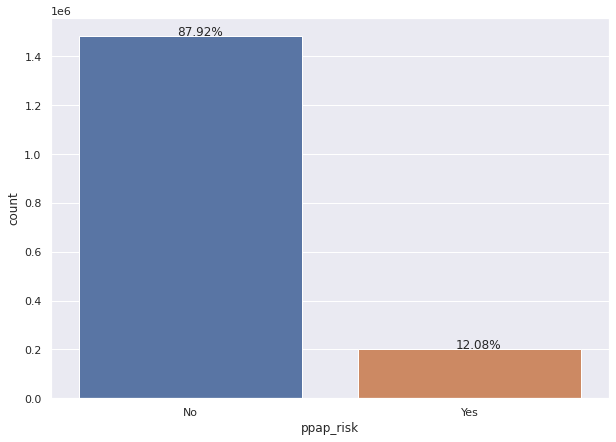

In [244]:
# Count plot of ppap_risk

feature='ppap_risk'
plt.figure(figsize=(10,7))
plt.xlabel(feature,size=12)
plt.ylabel('count',size=12)
ax=sns.countplot(x=feature, data=df_train) 
per_annot(df_train,feature)

* 87.92% potential_issue is flagged as "No" and 12.08% is flagged as "Yes" which suggest there is high imbalance in distribution of feature

went_on_backorder         No       Yes
ppap_risk                             
No                 99.357558  0.642442
Yes                99.137043  0.862957


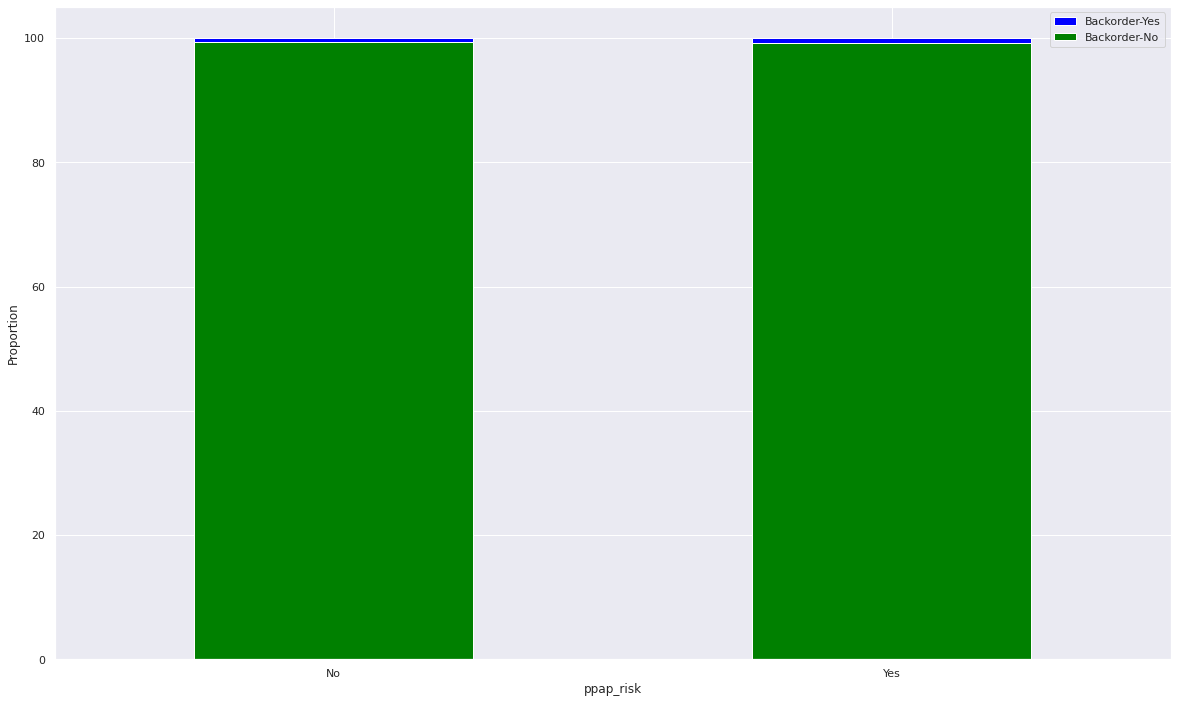

In [245]:
#Bar Plot for ppap_risk vs went_on_backorder

feature='ppap_risk'
target_variable="went_on_backorder"
categorical_plot(feature,target_variable)


* When the ppap_risk  is "Yes" , 0.9 % products went to backorder
* When the ppap_risk  is "No" , 0.6 % products went to backorder
* Since the distribution is almost similiar this feature do not seem to have impact on the backorders

In [246]:
# Count of each category in stop_auto_buy

df_train.stop_auto_buy.value_counts()

Yes    1626774
No       61086
Name: stop_auto_buy, dtype: int64

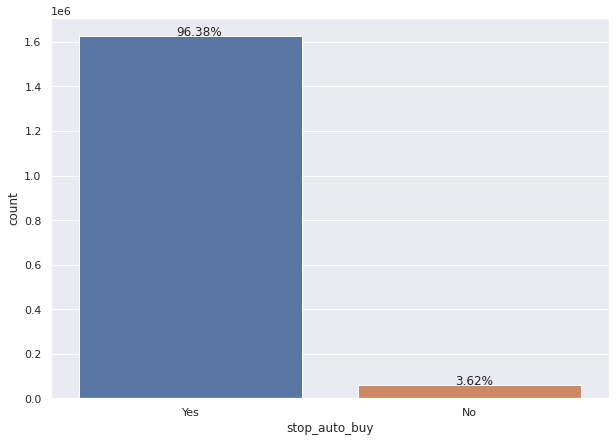

In [247]:
# Count plot of stop_auto_buy

feature='stop_auto_buy'
plt.figure(figsize=(10,7))
plt.xlabel(feature,size=12)
plt.ylabel('count',size=12)
ax=sns.countplot(x=feature, data=df_train) 
per_annot(df_train,feature)

* 96.38% stop_auto_buy is flagged as "Yes" and 3.628% is flagged as "No" which suggest there is high imbalance in distribution of feature

went_on_backorder         No       Yes
stop_auto_buy                         
No                 99.228956  0.771044
Yes                99.334757  0.665243


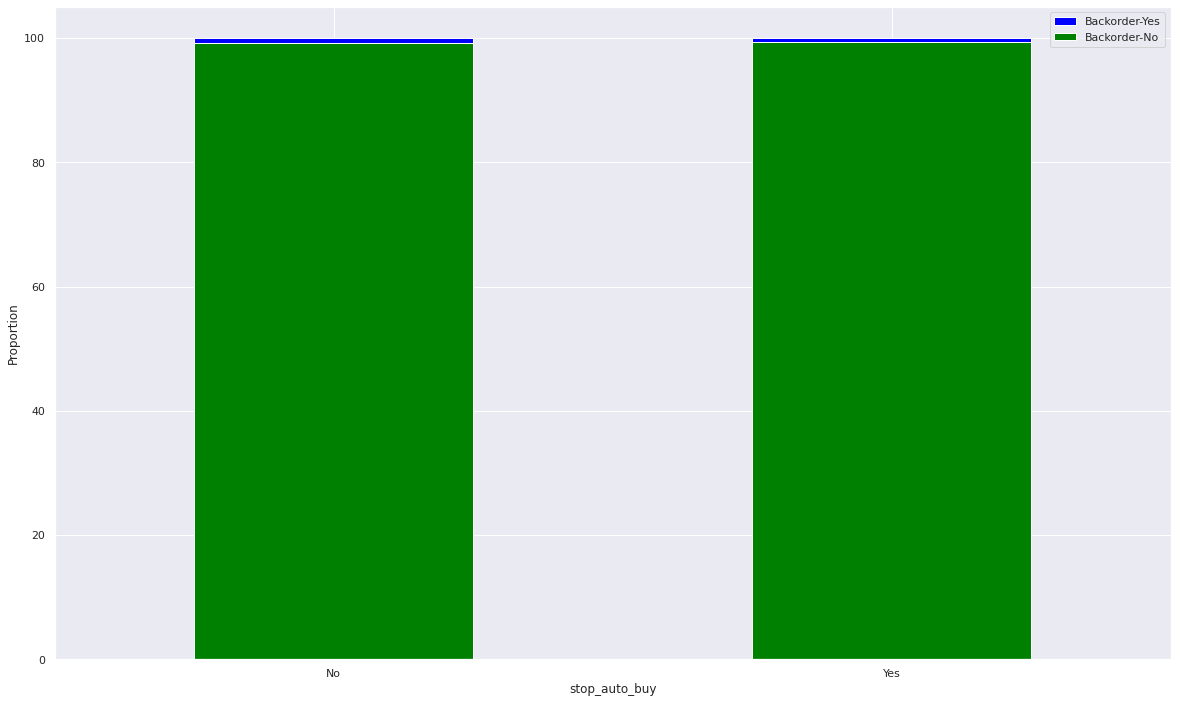

In [248]:
#Bar Plot for stop_auto_buy vs went_on_backorder

feature='stop_auto_buy'
target_variable="went_on_backorder"
categorical_plot(feature,target_variable)

* When the stop_auto_buy  is "Yes" , 0.7 % products went to backorder
* When the stop_auto_buy  is "No" , 0.7 % products went to backorder
* Since the distribution is almost similiar this feature do not seem to have impact on the backorders

In [249]:
# Count of each category in rev_stop

df_train.rev_stop.value_counts()

No     1687129
Yes        731
Name: rev_stop, dtype: int64

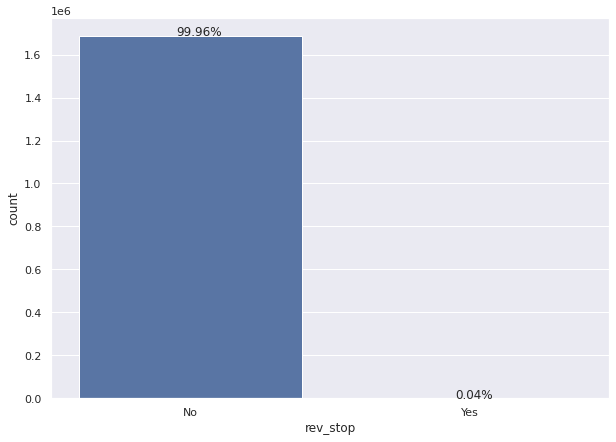

In [250]:
# Count plot of rev_stop

feature='rev_stop'
plt.figure(figsize=(10,7))
plt.xlabel(feature,size=12)
plt.ylabel('count',size=12)
ax=sns.countplot(x=feature, data=df_train) 
per_annot(df_train,feature)

* 99.96% rev_stop is flagged as "No" and 0.04% is flagged as "Yes" which suggest there is high imbalance in distribution of feature

went_on_backorder          No       Yes
rev_stop                               
No                  99.330638  0.669362
Yes                100.000000       NaN


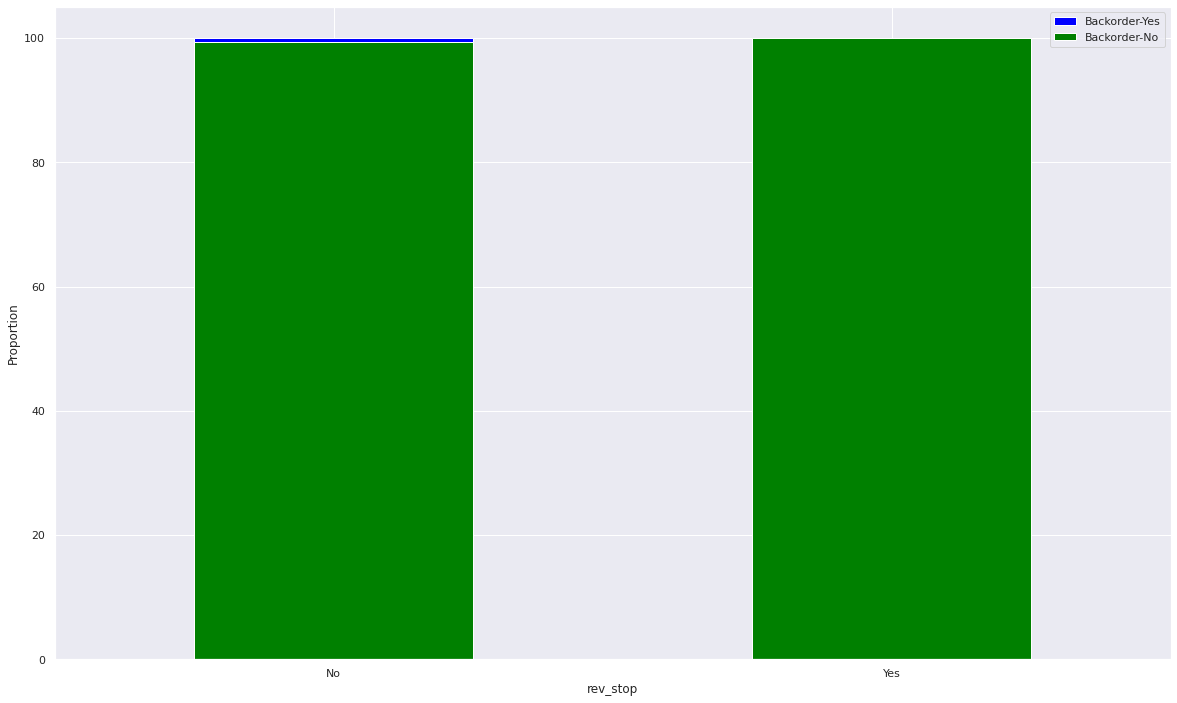

In [251]:
#Bar Plot for rev_stop vs went_on_backorder

feature='rev_stop'
target_variable="went_on_backorder"
categorical_plot(feature,target_variable)

* When the rev_stop  is "Yes" , no products went to backorder
* When the rev_stop  is "No" , 0.7 % products went to backorder
* This feature could be important in predicting backorders


### 2.5.3 Correlation between categorical variables using ChiSquare Test

In [252]:
df_train_cat_feat = df_train.select_dtypes(include=[np.object])

In [253]:
# referred from https://stackoverflow.com/questions/48035381/correlation-among-multiple-categorical-variables-pandas

from scipy.stats import chisquare
df = df_train_cat_feat.drop(['sku'], axis=1)
df=df.apply(lambda x : pd.factorize(x)[0])+1

pd.DataFrame([chisquare(df[x].values,f_exp=df.values.T,axis=1)[0] for x in df], columns=df.columns, index=df.columns)

,potential_issue,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
potential_issue,0.0,194278.0,1019.0,102489.5,31427.5,1272.5,6477.0
deck_risk,387566.0,0.0,387517.0,406313.5,369156.0,387790.0,390255.5
oe_constraint,688.0,193898.0,0.0,102081.0,30788.0,610.5,5879.5
ppap_risk,203953.0,314489.0,203875.5,0.0,218172.5,203727.0,206842.0
stop_auto_buy,61517.0,205957.5,61208.5,146798.5,0.0,60919.0,66026.0
rev_stop,1184.5,194414.0,853.5,102175.5,30741.5,0.0,6377.5
went_on_backorder,11670.0,202160.5,11403.5,110571.5,41129.5,11658.5,0.0


* Potential issue,rev_stop and oe_constraint have some type of correlation with each other.They also have some correlation with the target variable which might be useful for classification.


## 2.6 Bivariate Analysis

### 2.6.1 Bivariate Analysis of numerical features

In [254]:
#Selecting numerical features
df_train_num_feat=df_train.drop(columns=['sku','potential_issue','deck_risk','oe_constraint','ppap_risk','stop_auto_buy','rev_stop'],axis=1)

#Replacing missing values
df_train_num_feat.perf_6_month_avg.replace({-99.0 : np.nan}, inplace = True)
df_train_num_feat.perf_12_month_avg.replace({-99.0 : np.nan}, inplace = True)

df_train_num_feat['lead_time'] = SimpleImputer(strategy='median').fit_transform(df_train_num_feat['lead_time'].values.reshape(-1, 1))
df_train_num_feat['perf_6_month_avg'] = SimpleImputer(strategy='median').fit_transform(df_train_num_feat['perf_6_month_avg'].values.reshape(-1, 1))
df_train_num_feat['perf_12_month_avg'] = SimpleImputer(strategy='median').fit_transform(df_train_num_feat['perf_12_month_avg'].values.reshape(-1, 1))

In [255]:
df_train_num_feat_sc = StandardScaler().fit_transform(df_train_num_feat[num_col_list].values)

In [256]:
df_train_num_feat_sc = pd.DataFrame(df_train_num_feat_sc, index=df_train.index, columns=num_col_list)

In [257]:
for i in num_col_list:
  df_train_num_feat[i]=df_train_num_feat_sc[i]

In [258]:
#Random Undersampling points in order to make some useful observation

df_train_n = df_train_num_feat[df_train_num_feat['went_on_backorder'] == 'No']
df_train_p = df_train_num_feat[df_train_num_feat['went_on_backorder'] == 'Yes']
cnt_pos=df_train_p.shape[0]

# Creating undersampled data
df_train_n_under = df_train_n.sample(cnt_pos)
df_train_under = pd.concat([df_train_n_under, df_train_p], axis=0)

Bivariate Analysis of Sales features

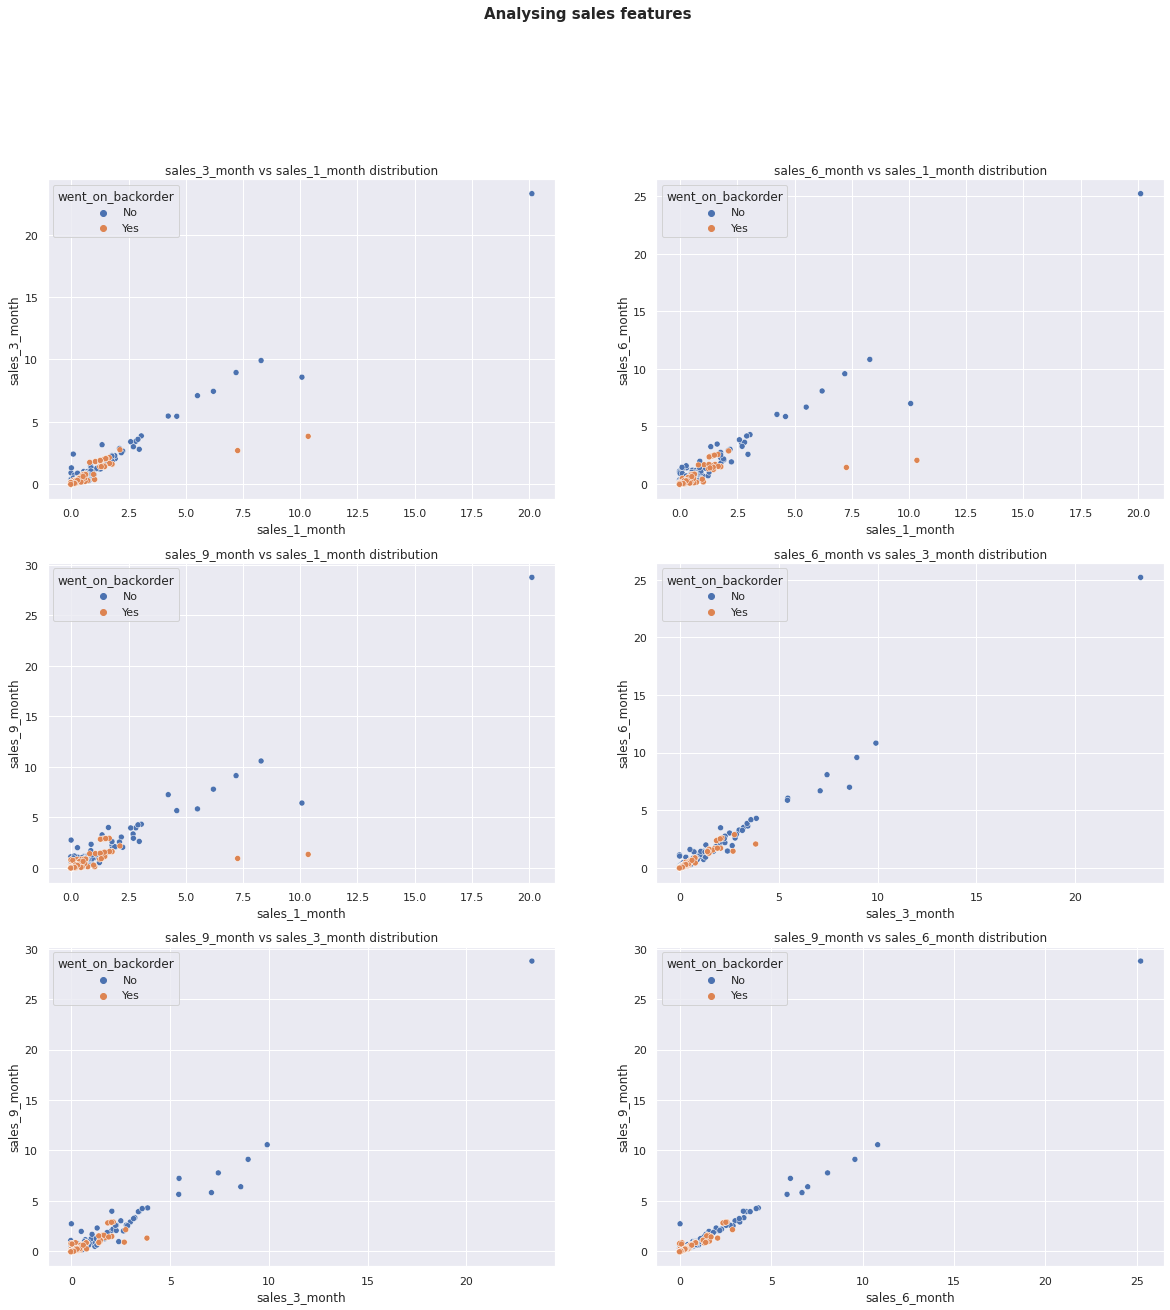

In [259]:
feat_list=['sales_1_month','sales_3_month','sales_6_month','sales_9_month']
fig = plt.figure(figsize=(20,20))
fig.tight_layout(pad=3.0)
fig.suptitle("Analysing sales features", fontsize=15, y=1, x=.5,weight='bold')

for idx,val in enumerate(itertools.combinations(feat_list,2)):
  ax1=fig.add_subplot(3,2 , idx+1)
  ax1.title.set_text(val[1]+' vs '+val[0]+' distribution')
  sns.scatterplot(x=val[0], y=val[1], data=df_train_under, hue='went_on_backorder')
plt.show()

* All sales features have linear relationship with each other. If the sales have been increasing over previous one month then it has also increased in the previous 9 months
* There are more number of backorders when the sales have been less

Bivariate Analysis of forecast features

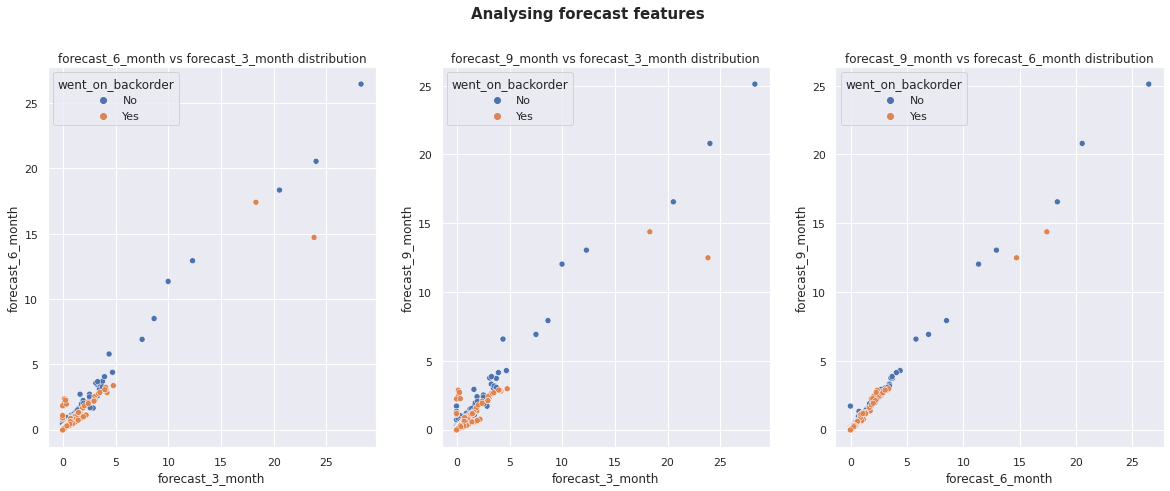

In [260]:
feat_list=['forecast_3_month','forecast_6_month', 'forecast_9_month']
fig = plt.figure(figsize=(20,7))
fig.tight_layout()
fig.suptitle("Analysing forecast features", fontsize=15, y=1, x=.5,weight='bold')

for idx,val in enumerate(itertools.combinations(feat_list,2)):
  ax1=fig.add_subplot(1,3 , idx+1)
  ax1.title.set_text(val[1]+' vs '+val[0]+' distribution')
  sns.scatterplot(x=val[0], y=val[1], data=df_train_under, hue='went_on_backorder')
plt.show()

* All forecast features have linear relationship with each other.If the forecast have been high for one month then it has also been high for next 9 months
* There are more items which have gone to backorder when the forecast have been high

Bivariate Analysis of perfomance columns

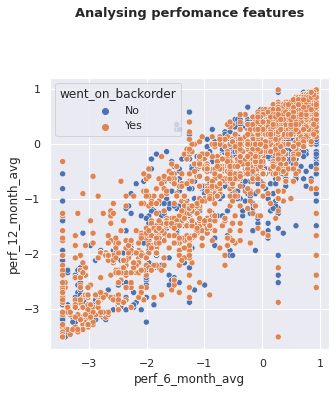

In [261]:
feat_list=['perf_6_month_avg','perf_12_month_avg']
plt.figure(figsize=(5,5))
plt.title("Analysing perfomance features", fontsize=13,y=1.2,weight='bold')
ax.title.set_text(feat_list[1]+' vs '+feat_list[0]+' distribution')
sns.scatterplot(x=feat_list[0], y=feat_list[1], data=df_train_under, hue='went_on_backorder')
plt.show()

* Perfomance columns have linear relationship with each other
* More products are going into backorder if the perfomance is high

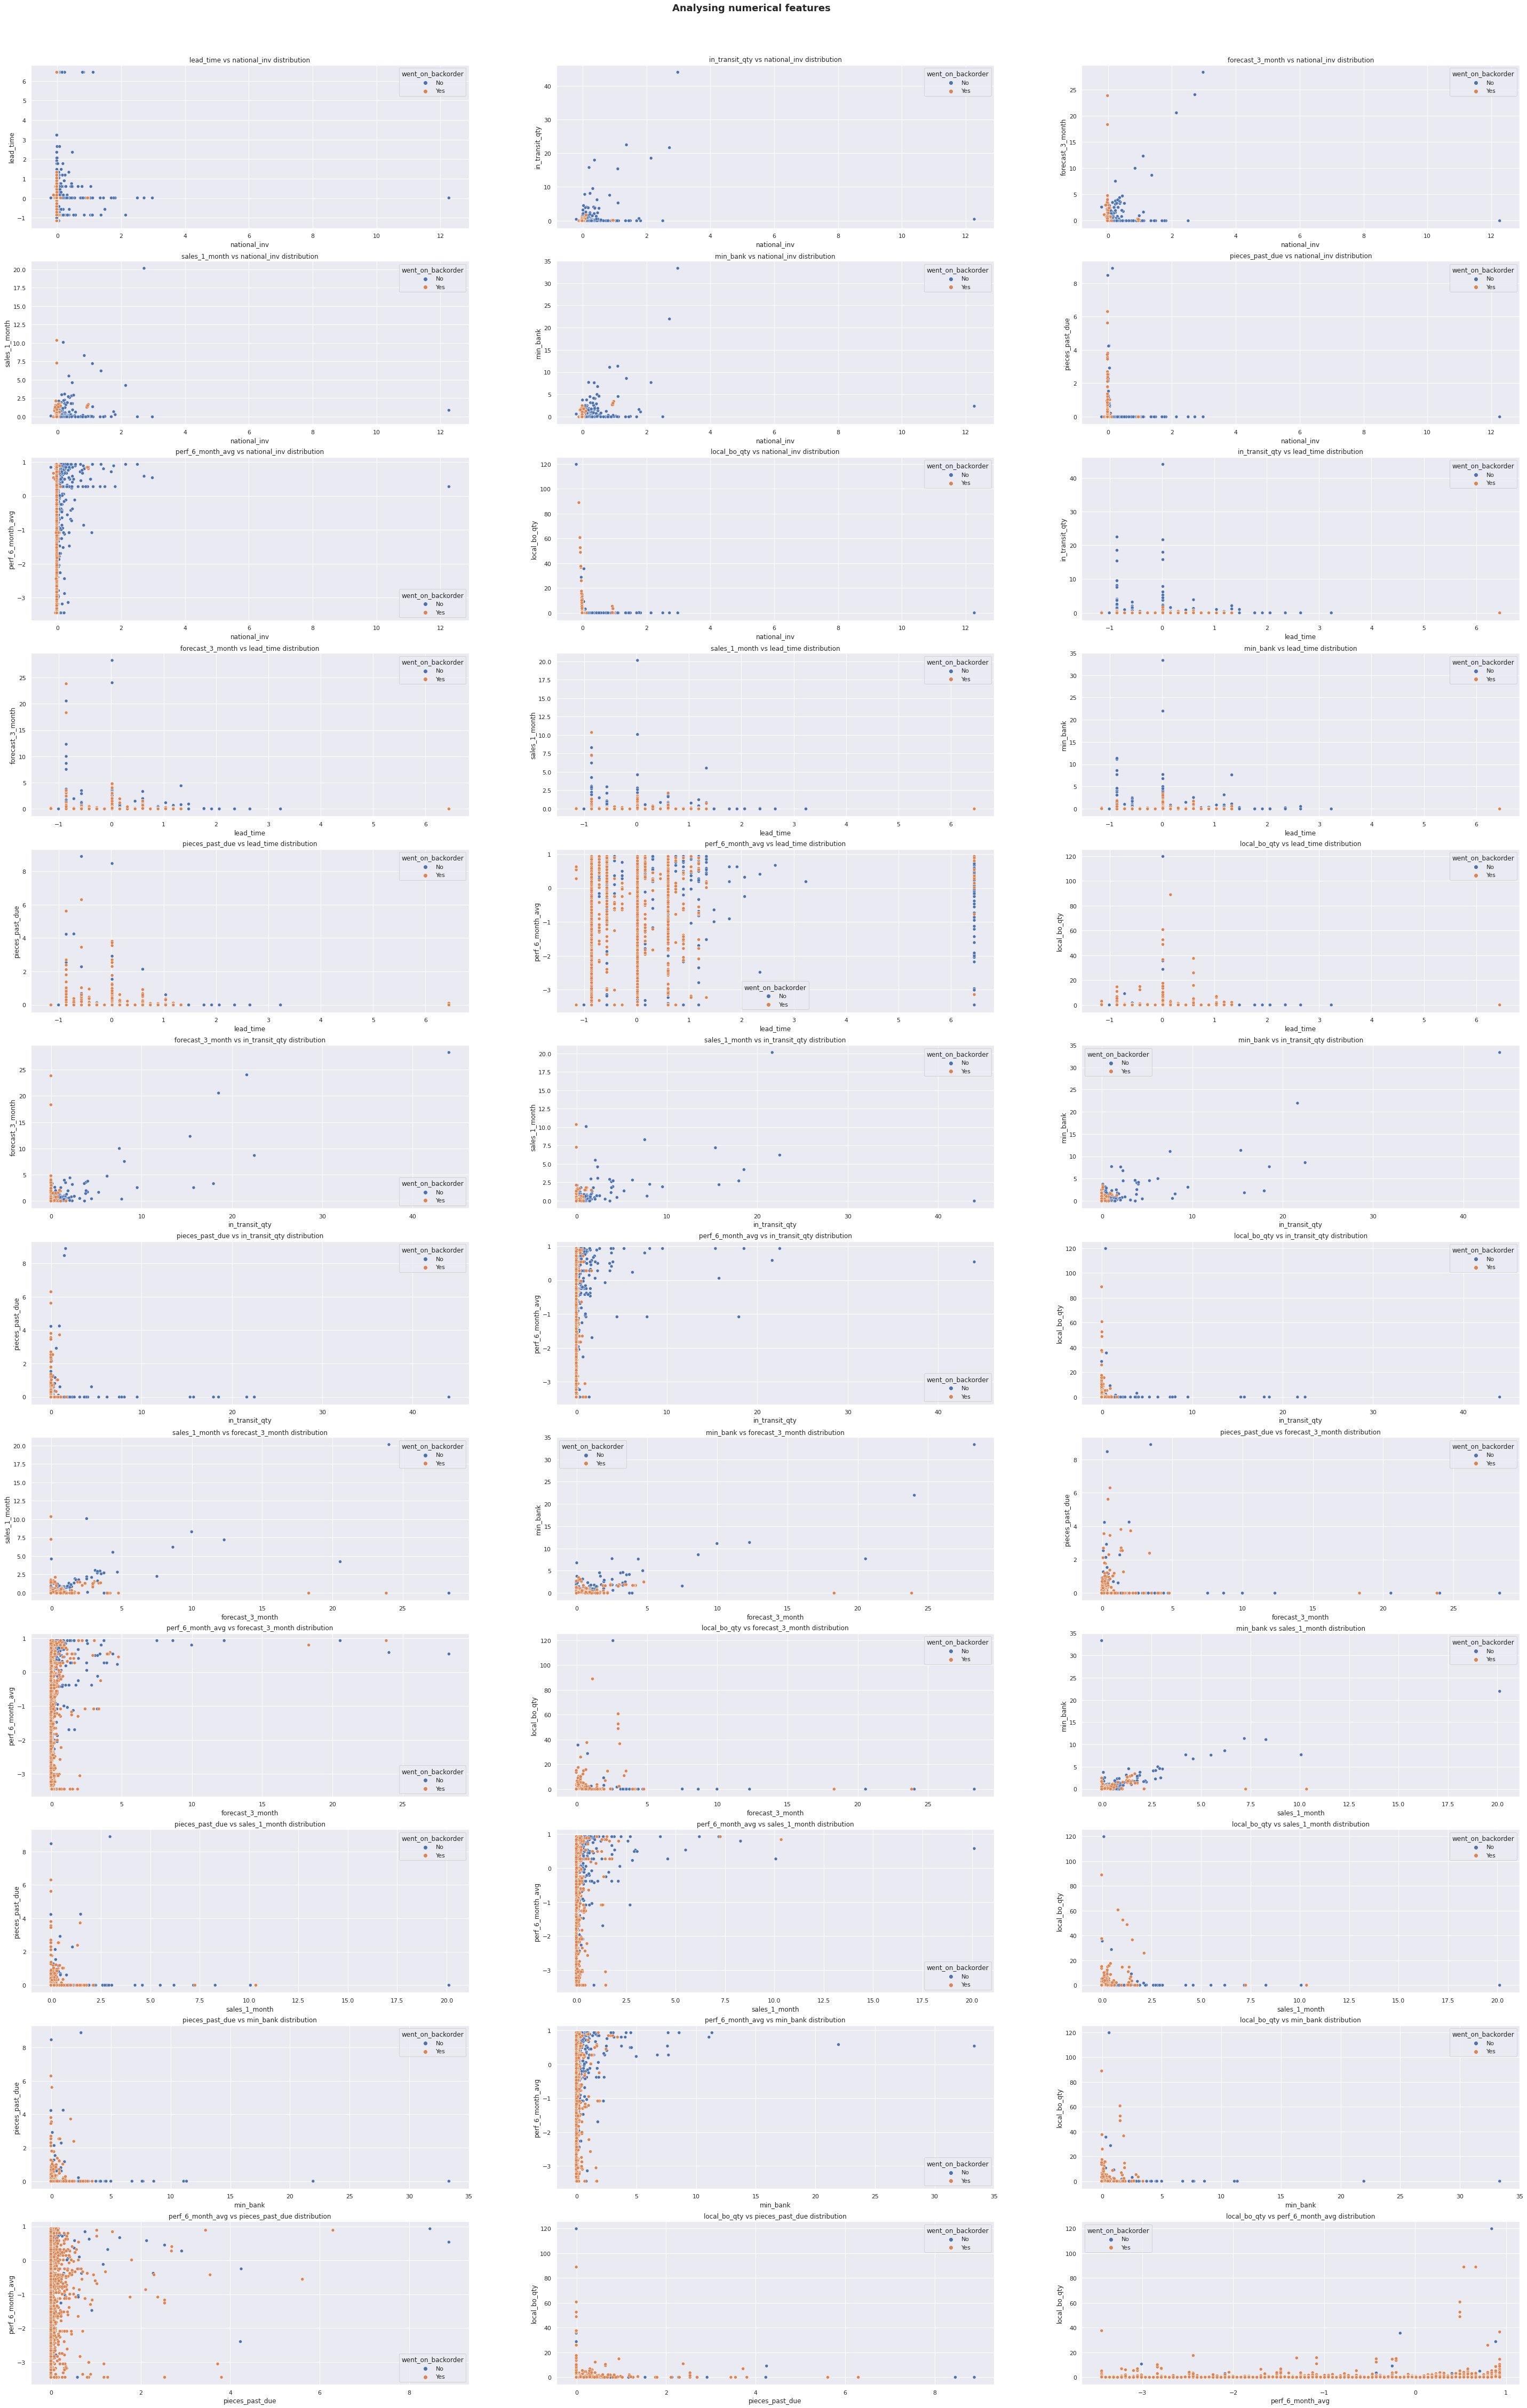

In [262]:
###forecast and sales have similiar distribution we have taken latest from each group for plot
###perfomance has similiar distribution for six and 12 months so latest perfomance column is taken for plot
feat_list=['national_inv','lead_time', 'in_transit_qty' , 'forecast_3_month', 'sales_1_month', 'min_bank', 'pieces_past_due', 'perf_6_month_avg', 'local_bo_qty']
fig = plt.figure(figsize=(50,80))
fig.tight_layout()
fig.suptitle("Analysing numerical features", fontsize=18, y=0.9, x=.5,weight='bold')

for idx,val in enumerate(itertools.combinations(feat_list,2)):
  ax1=fig.add_subplot(12,3 , idx+1)
  ax1.title.set_text(val[1]+' vs '+val[0]+' distribution')
  sns.scatterplot(x=val[0], y=val[1], data=df_train_under, hue='went_on_backorder')
plt.show()

* Lower national_inv values clearly have more backorders.This is obvious as negative values indicate the product is out of stock
* The product goes into backorder when either sales or forecast is low
* Low min_bank value show more products went into backorder.
This is true relationship since less minimum amount of stock will result into higher backorders.
* With lower lead time products have higher changes to go into backorder
* With lower in_transit_qty products have higher changes to go into backorder
This is true since less products that are moved to inventory will lead to more backorders.
* Higher local_bo_qty which is number of stock orders which are overdue, the items are more prone to move into backorder